# Import

In [ ]:
import json
from datetime import datetime
import os
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt

# Import the unified error classifier
import sys
sys.path.insert(0, '.')
from utils.unified_error_classifier import classify_response, ErrorType

from tqdm import tqdm
from utils.create_tests_metadata import get_or_create_tests_metadata
from utils.clean_server_errors import get_or_create_cleaned_results

from typing import Callable
import numpy as np

from utils.bayes_bootstrap import bayes_bootstrap_single, bayes_bootstrap_delta, bayes_bootstrap_delta_clustered, bayes_bootstrap_delta_internal_clustering, bayes_bootstrap_single_internal_clustering, save_bootstrap_run

In [ ]:
# Import merged results, clean server errors, and load tests metadata

MERGED_RESULTS_FILE = "preprocessed_merged_results.json"

# Get or create cleaned results (removes runs with server errors)
runs, cleaned_filepath = get_or_create_cleaned_results(MERGED_RESULTS_FILE)
print(f"Working with {len(runs)} cleaned runs")

"""
Expected format for `runs` (list of dicts):
[
    {
        "run_id": str,                   # Unique run UUID (was "runId" in older format)
        "test_id": str,                  # Runtime test ID (UUID)
        "test_name": str,                # Human-readable test name
        "model": str,                    # Model identifier (e.g., "deepseek/deepseek-v3.2")
        "service": str,                  # Service: "slack", "box", "calendar", "linear"
        "prompt": str,                   # Task prompt given to the agent
        "status": str,                   # "passed", "failed", "timeout", "error"
        "passed": bool,                  # Boolean pass/fail
        "score": float,                  # Weighted score = base_score * n_assertions (DO NOT use for analysis)
        "base_score": float,             # Original score 0-100 (USE THIS for qualitative analysis)
        "time": float,                   # Execution time in seconds
        "failures": list,                # List of failure messages (if any)
        "include_api_docs": bool,        # Whether API docs were in system prompt
        "trace": {                       # Full execution trace
            "steps": [...],              # List of step dicts (thinking, action, observation)
            "final": {...},              # Final iteration (thinking, summary)
            "iterations": int,           # Total iterations
            "completed": bool,
            "usage": {...}               # Token usage stats
        },
        "diff": {...},                   # State diff (inserts, deletes, updates)
        ...
    },
    ...
]
"""

# Get or create tests metadata (maps runtime_test_id -> test info)
tests_metadata = get_or_create_tests_metadata(
    merged_results_path=MERGED_RESULTS_FILE,
    test_suites_folder="test_suites",
    output_folder="tests_metadata"
)
print(f"Loaded metadata for {len(tests_metadata)} tests")

"""
Expected format for `tests_metadata` (dict):
{
    "<runtime_test_id>": {
        "test_suite_name": str,          # e.g., "Slack Bench v2"
        "test_suite_test_id": str        # e.g., "test_1"
    },
    ...
}
"""

QUALITATIVE_ANALYSIS_FILE = "qualitative_analysis_results/analysis_results_20260208_163451.json"
with open(QUALITATIVE_ANALYSIS_FILE, "r") as f:
    qualitative_analysis = json.load(f)
print(f"Loaded {len(qualitative_analysis)} from {QUALITATIVE_ANALYSIS_FILE}") 

"""
Expected format for `qualitative_analysis` (list of dicts):
[
    {
        "run_id": str,                   # Unique run UUID
        "runtime_test_id": str,          # Runtime test ID (UUID)
        "compared_against": str,         # run_id of the reference run used for comparison
        "run_analysis": {
            "tool_use_errors": {         # Nested under tool_use_errors (4 subtypes)
                "endpoint_selection": {"present": bool, "explanation": str, "example": str},
                "parameter_misuse": {"present": bool, "explanation": str, "example": str},
                "format_errors": {"present": bool, "explanation": str, "example": str},
                "code_errors": {"present": bool, "explanation": str, "example": str}
            },
            "model_refusal": {"present": bool, "explanation": str, "example": str},
            "hallucination_errors": {    # 7 subtypes
                "parameter_hallucination": {"present": bool, "example": str},
                "outcome_hallucination": {"present": bool, "example": str},
                "state_hallucination": {"present": bool, "example": str},
                "action_hallucination": {"present": bool, "example": str},
                "capability_hallucination": {"present": bool, "example": str},
                "context_hallucination": {"present": bool, "example": str},
                "other_hallucination": {"present": bool, "explanation": str, "example": str}
            },
            "reasoning_errors": {        # 18 subtypes (includes infinite_loop_error, premature_termination_error)
                "time_orientation_error": {"present": bool, "example": str},
                "state_tracking_error": {"present": bool, "example": str},
                "goal_misalignment_error": {"present": bool, "example": str},
                "causal_reasoning_error": {"present": bool, "example": str},
                "confirmation_bias": {"present": bool, "example": str},
                "logical_fallacy": {"present": bool, "example": str},
                "assumption_error": {"present": bool, "example": str},
                "negation_error": {"present": bool, "example": str},
                "scope_generalization_error": {"present": bool, "example": str},
                "dependency_ordering_error": {"present": bool, "example": str},
                "incomplete_execution_error": {"present": bool, "example": str},
                "premature_termination_error": {"present": bool, "example": str},
                "quantitative_reasoning_error": {"present": bool, "example": str},
                "reference_resolution_error": {"present": bool, "example": str},
                "instruction_fidelity_error": {"present": bool, "example": str},
                "reasoning_action_mismatch": {"present": bool, "example": str},
                "other_reasoning_error": {"present": bool, "explanation": str, "example": str},
                "infinite_loop_error": {"present": bool, "explanation": str, "example": str}
            },
            "recovery_strategies": {     # 15 subtypes
                "retry_same": {"present": bool, "example": str},
                "retry_modified_params": {"present": bool, "example": str},
                "switch_tool": {"present": bool, "example": str},
                "lookup_correct_value": {"present": bool, "example": str},
                "backtrack": {"present": bool, "example": str},
                "parse_error_message": {"present": bool, "example": str},
                "handle_ui_obstacle": {"present": bool, "example": str},
                "change_strategy": {"present": bool, "example": str},
                "break_into_steps": {"present": bool, "example": str},
                "verify_prerequisites": {"present": bool, "example": str},
                "skip_and_continue": {"present": bool, "example": str},
                "wait_and_retry": {"present": bool, "example": str},
                "use_fallback": {"present": bool, "example": str},
                "other_recovery_strategy": {"present": bool, "explanation": str, "example": str},
                "no_recovery_attempted": {"present": bool, "example": str}
            },
            "other_error": {"present": bool, "explanation": str, "example": str},
            "qualitative_summary": {     # 16 fields (5 scores)
                "planning_score": int,           # 0-5 planning quality score
                "planning_explanation": str,
                "reasoning_score": int,          # 0-5 reasoning quality score
                "reasoning_explanation": str,
                "tool_use_score": int,           # 0-5 API/tool handling score
                "tool_use_explanation": str,
                "recovery_score": int,           # 0-5 recovery ability score
                "recovery_explanation": str,
                "hallucination_score": int,      # 0-5 hallucination resistance (5=none, 0=severe)
                "hallucination_explanation": str,
                "overall_description": str,
                "key_insight": str,
                "model_behavior_pattern": str,
                "implications_for_reliability": str,
                "worthy_example": bool,
                "why_worthy_example": str
            }
        }
    },
    ...
]
"""


# Import test suites
TEST_SUITES_FOLDER = "test_suites"

test_suites = {}
for filename in os.listdir(TEST_SUITES_FOLDER):
    if filename.endswith(".json"):
        service_name = filename.replace("_bench.json", "").replace("_bench_v2.json", "")
        with open(os.path.join(TEST_SUITES_FOLDER, filename), "r") as f:
            suite = json.load(f)
            # Rename "Slack Bench v2 (Combined)" to "Slack Bench v2"
            if suite.get("name") == "Slack Bench v2 (Combined)":
                suite["name"] = "Slack Bench v2"
            test_suites[service_name] = suite

print(f"Loaded {len(test_suites)} test suites:")
for service, suite in test_suites.items():
    print(f"  {suite.get('name', service)}: {len(suite.get('tests', []))} tests")

"""
Expected format for `test_suites` (dict):
{
    "<service_name>": {                  # e.g., "slack", "linear", "calendar", "box"
        "id": str,                       # e.g., "slack-bench-v2"
        "name": str,                     # e.g., "Slack Bench v2"
        "description": str,
        "service": str,
        "ignore_fields": {...},
        "tests": [
            {
                "id": str,               # e.g., "test_1"
                "name": str,             # e.g., "Send message to general channel"
                "prompt": str,           # Task prompt
                "type": str,             # e.g., "actionEval"
                "seed_template": str,
                "impersonate_user_id": str,
                "metadata": {
                    "min_tool_calls": int,
                    "tools_required": [str, ...]
                },
                "assertions": [...]
            },
            ...
        ]
    },
    ...
}
"""

# Get or create tests metadata (maps runtime_test_id -> test info)
tests_metadata = get_or_create_tests_metadata(
    merged_results_path=MERGED_RESULTS_FILE,
    test_suites_folder="test_suites",
    output_folder="tests_metadata"
)

print(f"Loaded metadata for {len(tests_metadata)} tests")

Loading existing cleaned results from: cleaned_preprocessed_merged_results_20260207_165600.json
Loaded 13516 cleaned runs
Working with 13516 cleaned runs
Loaded existing tests metadata with 224 tests
Loaded metadata for 224 tests
Loaded 3955 from qualitative_analysis_results/analysis_results_20260208_163451.json
Loaded 4 test suites:
  Slack Bench v2: 59 tests
  Linear Bench: 57 tests
  Calendar Bench: 60 tests
  Box Bench v2: 48 tests
Loaded existing tests metadata with 224 tests
Loaded metadata for 224 tests


# Preprocess

In [3]:
def create_combined_qualitative_data(
    runs: list[dict],
    qualitative_analysis: list[dict],
    test_suites: dict,
    tests_metadata: dict
) -> list[dict]:
    """
    Combine run data from multiple sources into a unified list of dicts,
    merging with qualitative_analysis and converting error presence to 0/1 format.
    
    Args:
        runs: List of run dicts (from cleaned merged results)
        qualitative_analysis: List of qualitative analysis dicts (flat list with run_analysis)
        test_suites: Dict of test suites by service name
        tests_metadata: Dict mapping runtime_test_id -> test suite info
    
    Returns:
        List of combined run dicts with error counts in 0/1 format
        
    Expected Format:
    {
        "run_id": str,
        "test_id": str,
        "service": str,                    # "slack", "box", "calendar", "linear"
        "prompt_len": int,
        "n_assertions": int,
        "min_tool_calls": int,
        "iterations": int,
        "model": str,
        "score": float,                    # base_score (0-100)
        "weighted_score": float,           # base_score * n_assertions
        "status": str,                     # "passed", "failed", "timeout"
        "include_api_docs": bool,
        "include_all_api_docs": bool,
        "compared_against": str,           # run_id of reference run
        "total_errors": int,               # sum of tool_use + model_refusal + other_error + hallucination + reasoning
        "tool_use_errors": {               # from nested tool_use_errors (4 subtypes)
            "total_tool_use_errors": int,
            "endpoint_selection": int,     # 0 or 1
            "parameter_misuse": int,
            "format_errors": int,
            "code_errors": int
        },
        "model_refusal": int,              # 0 or 1 (top-level, not nested)
        "other_error": int,                # 0 or 1 (top-level, not nested)
        "hallucination_errors": {          # 7 subtypes
            "total_hallucination_errors": int,
            "parameter_hallucination": int,
            "outcome_hallucination": int,
            "state_hallucination": int,
            "action_hallucination": int,
            "capability_hallucination": int,
            "context_hallucination": int,
            "other_hallucination": int
        },
        "reasoning_errors": {              # 18 subtypes (includes infinite_loop_error, premature_termination_error)
            "total_reasoning_errors": int,
            "time_orientation_error": int,
            "state_tracking_error": int,
            "goal_misalignment_error": int,
            "causal_reasoning_error": int,
            "confirmation_bias": int,
            "logical_fallacy": int,
            "assumption_error": int,
            "negation_error": int,
            "scope_generalization_error": int,
            "dependency_ordering_error": int,
            "incomplete_execution_error": int,
            "premature_termination_error": int,
            "quantitative_reasoning_error": int,
            "reference_resolution_error": int,
            "instruction_fidelity_error": int,
            "reasoning_action_mismatch": int,
            "other_reasoning_error": int,
            "infinite_loop_error": int
        },
        "recovery_strategies": {           # 15 subtypes
            "total_recovery_strategies": int,  # excludes no_recovery_attempted
            "retry_same": int,
            "retry_modified_params": int,
            "switch_tool": int,
            "lookup_correct_value": int,
            "backtrack": int,
            "parse_error_message": int,
            "handle_ui_obstacle": int,
            "change_strategy": int,
            "break_into_steps": int,
            "verify_prerequisites": int,
            "skip_and_continue": int,
            "wait_and_retry": int,
            "use_fallback": int,
            "other_recovery_strategy": int,
            "no_recovery_attempted": int
        },
        "qualitative_scores": {            # 5 scores from qualitative_summary
            "planning_score": int,
            "reasoning_score": int,
            "tool_use_score": int,
            "recovery_score": int,
            "hallucination_score": int
        }
    }
    """
    # Build run_id -> qualitative analysis lookup
    run_id_to_qualitative = {}
    for entry in qualitative_analysis:
        run_id = entry.get("run_id")
        if run_id:
            run_id_to_qualitative[run_id] = entry
    
    # Build test_suite_test_id -> test info mapping (for n_assertions, min_tool_calls)
    test_info_lookup = {}
    for service_name, suite in test_suites.items():
        for test in suite.get("tests", []):
            key = (suite["name"], test["id"])
            test_info_lookup[key] = {
                "n_assertions": len(test.get("assertions", [])),
                "min_tool_calls": test.get("metadata", {}).get("min_tool_calls", 0)
            }
    
    # Define error/strategy categories (updated for new schema)
    tool_use_error_keys = [
        "endpoint_selection", "parameter_misuse", "format_errors", "code_errors"
    ]
    hallucination_error_keys = [
        "parameter_hallucination", "outcome_hallucination", "state_hallucination",
        "action_hallucination", "capability_hallucination", "context_hallucination",
        "other_hallucination"
    ]
    reasoning_error_keys = [
        "time_orientation_error", "state_tracking_error", "goal_misalignment_error",
        "causal_reasoning_error", "confirmation_bias", "logical_fallacy",
        "assumption_error", "negation_error", "scope_generalization_error",
        "dependency_ordering_error", "incomplete_execution_error", "premature_termination_error",
        "quantitative_reasoning_error", "reference_resolution_error", "instruction_fidelity_error",
        "reasoning_action_mismatch", "other_reasoning_error", "infinite_loop_error"
    ]
    recovery_strategy_keys = [
        "retry_same", "retry_modified_params", "switch_tool", "lookup_correct_value",
        "backtrack", "parse_error_message", "handle_ui_obstacle", "change_strategy",
        "break_into_steps", "verify_prerequisites", "skip_and_continue", "wait_and_retry",
        "use_fallback", "other_recovery_strategy", "no_recovery_attempted"
    ]
    
    def get_present_as_int(data: dict, key: str) -> int:
        """Extract 'present' field as 0/1 from nested dict."""
        return 1 if data.get(key, {}).get("present", False) else 0
    
    combined_data = []
    
    for run in runs:
        run_id = run.get("runId") or run.get("run_id")
        
        # Skip runs that don't have qualitative analysis
        if run_id not in run_id_to_qualitative:
            continue
        
        test_id = run.get("test_id")
        service = run.get("service", "unknown")
        
        # Get prompt length
        prompt = run.get("prompt") or ""
        prompt_len = len(prompt)
        
        # Get iterations from trace
        trace = run.get("trace", {})
        iterations = trace.get("iterations", 0) if isinstance(trace, dict) else 0
        
        # Get n_assertions and min_tool_calls from test_suites via tests_metadata
        n_assertions = 0
        min_tool_calls = 0
        if test_id and test_id in tests_metadata:
            meta = tests_metadata[test_id]
            test_suite_name = meta.get("test_suite_name")
            test_suite_test_id = meta.get("test_suite_test_id")
            key = (test_suite_name, test_suite_test_id)
            if key in test_info_lookup:
                n_assertions = test_info_lookup[key]["n_assertions"]
                min_tool_calls = test_info_lookup[key]["min_tool_calls"]
        
        # Get run_analysis from qualitative_analysis (guaranteed to exist due to filter above)
        qa_entry = run_id_to_qualitative[run_id]
        run_analysis = qa_entry.get("run_analysis")
        compared_against = qa_entry.get("compared_against")
        
        # Extract scores
        score = run["base_score"]
        weighted_score = run["score"]
        
        # Build error counts from run_analysis (updated for new schema structure)
        tool_use_errors = {k: 0 for k in tool_use_error_keys}
        model_refusal = 0
        other_error = 0
        hallucination_errors = {k: 0 for k in hallucination_error_keys}
        reasoning_errors = {k: 0 for k in reasoning_error_keys}
        recovery_strategies = {k: 0 for k in recovery_strategy_keys}
        qualitative_scores = {
            "planning_score": None,
            "reasoning_score": None,
            "tool_use_score": None,
            "recovery_score": None,
            "hallucination_score": None
        }
        
        if run_analysis:
            # Tool use errors (nested under tool_use_errors in new schema)
            tool_use_data = run_analysis.get("tool_use_errors", {})
            for key in tool_use_error_keys:
                tool_use_errors[key] = get_present_as_int(tool_use_data, key)
            
            # Top-level errors (not nested)
            model_refusal = 1 if run_analysis.get("model_refusal", {}).get("present", False) else 0
            other_error = 1 if run_analysis.get("other_error", {}).get("present", False) else 0
            
            # Hallucination errors (nested under hallucination_errors)
            hall_data = run_analysis.get("hallucination_errors", {})
            for key in hallucination_error_keys:
                hallucination_errors[key] = get_present_as_int(hall_data, key)
            
            # Reasoning errors (nested under reasoning_errors, includes infinite_loop_error)
            reason_data = run_analysis.get("reasoning_errors", {})
            for key in reasoning_error_keys:
                reasoning_errors[key] = get_present_as_int(reason_data, key)
            
            # Recovery strategies (nested under recovery_strategies)
            recovery_data = run_analysis.get("recovery_strategies", {})
            for key in recovery_strategy_keys:
                recovery_strategies[key] = get_present_as_int(recovery_data, key)
            
            # Qualitative scores from qualitative_summary (5 scores in new schema)
            qual_summary = run_analysis.get("qualitative_summary", {})
            qualitative_scores["planning_score"] = qual_summary.get("planning_score")
            qualitative_scores["reasoning_score"] = qual_summary.get("reasoning_score")
            qualitative_scores["tool_use_score"] = qual_summary.get("tool_use_score")
            qualitative_scores["recovery_score"] = qual_summary.get("recovery_score")
            qualitative_scores["hallucination_score"] = qual_summary.get("hallucination_score")
        
        # Calculate totals
        total_tool_use_errors = sum(tool_use_errors.values())
        total_hallucination_errors = sum(hallucination_errors.values())
        total_reasoning_errors = sum(reasoning_errors.values())
        # Exclude no_recovery_attempted from total (it indicates opposite of recovery)
        total_recovery_strategies = sum(v for k, v in recovery_strategies.items() if k != "no_recovery_attempted")
        
        # total_errors = tool_use + model_refusal + other_error + hallucination + reasoning
        total_errors = total_tool_use_errors + model_refusal + other_error + total_hallucination_errors + total_reasoning_errors
        
        # Add totals to dicts
        tool_use_errors["total_tool_use_errors"] = total_tool_use_errors
        hallucination_errors["total_hallucination_errors"] = total_hallucination_errors
        reasoning_errors["total_reasoning_errors"] = total_reasoning_errors
        recovery_strategies["total_recovery_strategies"] = total_recovery_strategies
        
        combined_run = {
            "run_id": run_id,
            "test_id": test_id,
            "service": service,
            "prompt_len": prompt_len,
            "n_assertions": n_assertions,
            "min_tool_calls": min_tool_calls,
            "iterations": iterations,
            "model": run["model"],
            "score": score,
            "weighted_score": weighted_score,
            "status": run["status"],
            "include_api_docs": run.get("include_api_docs", False),
            "include_all_api_docs": run.get("include_all_api_docs", False),
            "compared_against": compared_against,
            "total_errors": total_errors,
            "tool_use_errors": tool_use_errors,
            "model_refusal": model_refusal,
            "other_error": other_error,
            "hallucination_errors": hallucination_errors,
            "reasoning_errors": reasoning_errors,
            "recovery_strategies": recovery_strategies,
            "qualitative_scores": qualitative_scores
        }
        
        combined_data.append(combined_run)
    
    return combined_data


# Create combined qualitative dataset
combined_qualitative_runs = create_combined_qualitative_data(
    runs=runs,
    qualitative_analysis=qualitative_analysis,
    test_suites=test_suites,
    tests_metadata=tests_metadata
)

# Report stats
print(f"Created combined qualitative dataset with {len(combined_qualitative_runs)} runs")
print(f"  (Only includes runs present in qualitative_analysis)")

# Show sample
print("\nSample run (first with analysis):")
for r in combined_qualitative_runs:
    if r["qualitative_scores"]["planning_score"] is not None:
        print(f"  run_id: {r['run_id'][:8]}...")
        print(f"  total_errors: {r['total_errors']}")
        print(f"  tool_use_errors: {r['tool_use_errors']}")
        print(f"  model_refusal: {r['model_refusal']}")
        print(f"  other_error: {r['other_error']}")
        print(f"  hallucination_errors total: {r['hallucination_errors']['total_hallucination_errors']}")
        print(f"  reasoning_errors total: {r['reasoning_errors']['total_reasoning_errors']}")
        print(f"  recovery_strategies total: {r['recovery_strategies']['total_recovery_strategies']}")
        print(f"  qualitative_scores: {r['qualitative_scores']}")
        break

# Save combined qualitative data to JSON for quantitative evaluation
output_path = "analysis_preprocessed_for_quantitative_evaluation.json"
with open(output_path, 'w') as f:
    json.dump(combined_qualitative_runs, f, indent=2)
print(f"\nSaved {len(combined_qualitative_runs)} runs to {output_path}")

Created combined qualitative dataset with 3955 runs
  (Only includes runs present in qualitative_analysis)

Sample run (first with analysis):
  run_id: aa987186...
  total_errors: 0
  tool_use_errors: {'endpoint_selection': 0, 'parameter_misuse': 0, 'format_errors': 0, 'code_errors': 0, 'total_tool_use_errors': 0}
  model_refusal: 0
  other_error: 0
  hallucination_errors total: 0
  reasoning_errors total: 0
  recovery_strategies total: 0
  qualitative_scores: {'planning_score': 5, 'reasoning_score': 5, 'tool_use_score': 5, 'recovery_score': 5, 'hallucination_score': 5}

Saved 3955 runs to analysis_preprocessed_for_quantitative_evaluation.json


In [4]:
def filter_sparse_categories(combined_runs: list[dict]) -> tuple[list[dict], dict]:
    """
    Filter out error/recovery categories that appear 0 times across all runs.
    
    Args:
        combined_runs: List of combined qualitative run dicts
        
    Returns:
        (filtered_runs, stats) where:
        - filtered_runs: New list with sparse categories removed from each run
        - stats: Dict with counts, removed, and kept categories per group
    """
    # Count occurrences across all runs (updated for new schema)
    # Note: model_refusal and other_error are top-level ints, not nested dicts
    counts = {
        "tool_use_errors": defaultdict(int),
        "hallucination_errors": defaultdict(int),
        "reasoning_errors": defaultdict(int),
        "recovery_strategies": defaultdict(int)
    }
    
    # Count top-level error fields separately
    top_level_counts = {
        "model_refusal": 0,
        "other_error": 0
    }
    
    for run in combined_runs:
        # Count nested error categories
        for group_name in counts.keys():
            group = run.get(group_name, {})
            for key, value in group.items():
                if not key.startswith("total_"):  # Skip total fields
                    counts[group_name][key] += value
        
        # Count top-level fields
        top_level_counts["model_refusal"] += run.get("model_refusal", 0)
        top_level_counts["other_error"] += run.get("other_error", 0)
    
    # Identify zero-count and kept categories for nested groups
    removed = {}
    kept = {}
    for group_name, group_counts in counts.items():
        removed[group_name] = [k for k, v in sorted(group_counts.items()) if v == 0]
        kept[group_name] = [k for k, v in sorted(group_counts.items()) if v > 0]
    
    # Report
    print("=" * 60)
    print("SPARSE CATEGORY ANALYSIS")
    print("=" * 60)
    
    print("\nTop-level error counts:")
    print(f"  model_refusal: {top_level_counts['model_refusal']}")
    print(f"  other_error: {top_level_counts['other_error']}")
    
    print("\nCategories with 0 occurrences (will be removed):")
    total_removed = 0
    for group_name, removed_keys in removed.items():
        if removed_keys:
            print(f"  {group_name}: {removed_keys}")
            total_removed += len(removed_keys)
        else:
            print(f"  {group_name}: (none)")
    
    print(f"\nTotal categories removed: {total_removed}")
    
    print("\nCategories kept (with occurrence counts):")
    for group_name, kept_keys in kept.items():
        print(f"\n  {group_name} ({len(kept_keys)} categories):")
        for key in kept_keys:
            print(f"    - {key}: {counts[group_name][key]}")
    
    # Create filtered runs
    filtered_runs = []
    for run in combined_runs:
        # Copy all fields except the nested error/recovery dicts
        new_run = {k: v for k, v in run.items() 
                   if k not in ["tool_use_errors", "hallucination_errors", 
                                "reasoning_errors", "recovery_strategies"]}
        
        # Filter nested categories
        for group_name in counts.keys():
            old_group = run.get(group_name, {})
            new_group = {}
            for key, value in old_group.items():
                if key.startswith("total_") or key in kept[group_name]:
                    new_group[key] = value
            new_run[group_name] = new_group
        
        filtered_runs.append(new_run)
    
    stats = {
        "counts": {g: dict(c) for g, c in counts.items()},
        "top_level_counts": top_level_counts,
        "removed": removed,
        "kept": kept
    }
    
    return filtered_runs, stats


# Filter sparse categories
filtered_runs, filter_stats = filter_sparse_categories(combined_qualitative_runs)

print(f"\n\nFiltered dataset: {len(filtered_runs)} runs")
print(f"Sample filtered run tool_use_errors: {filtered_runs[0]['tool_use_errors']}")
print(f"Sample filtered run model_refusal: {filtered_runs[0]['model_refusal']}")
print(f"Sample filtered run other_error: {filtered_runs[0]['other_error']}")

# Save combined qualitative data to JSON for quantitative evaluation
output_path = "filtered_analysis_preprocessed_for_quantitative_evaluation.json"
with open(output_path, 'w') as f:
    json.dump(filtered_runs, f, indent=2)
print(f"\nSaved {len(filtered_runs)} runs to {output_path}")

SPARSE CATEGORY ANALYSIS

Top-level error counts:
  model_refusal: 76
  other_error: 70

Categories with 0 occurrences (will be removed):
  tool_use_errors: (none)
  hallucination_errors: (none)
  reasoning_errors: ['negation_error']
  recovery_strategies: ['handle_ui_obstacle']

Total categories removed: 2

Categories kept (with occurrence counts):

  tool_use_errors (4 categories):
    - code_errors: 634
    - endpoint_selection: 406
    - format_errors: 367
    - parameter_misuse: 1317

  hallucination_errors (7 categories):
    - action_hallucination: 550
    - capability_hallucination: 68
    - context_hallucination: 288
    - other_hallucination: 208
    - outcome_hallucination: 1118
    - parameter_hallucination: 959
    - state_hallucination: 1065

  reasoning_errors (17 categories):
    - assumption_error: 1388
    - causal_reasoning_error: 315
    - confirmation_bias: 420
    - dependency_ordering_error: 221
    - goal_misalignment_error: 522
    - incomplete_execution_error:

# Analyze

## Failure modes analysis

In [5]:
# Check doc level distribution per model
doc_by_model = defaultdict(lambda: {"none": 0, "relevant": 0, "all": 0})
for run in filtered_runs:
    model = run["model"]
    if run.get("include_all_api_docs"):
        doc_by_model[model]["all"] += 1
    elif run.get("include_api_docs"):
        doc_by_model[model]["relevant"] += 1
    else:
        doc_by_model[model]["none"] += 1

for model, counts in sorted(doc_by_model.items()):
    total = sum(counts.values())
    print(f"{model}: {counts} (n={total})")


anthropic/claude-haiku-4.5: {'none': 221, 'relevant': 221, 'all': 0} (n=442)
deepseek/deepseek-v3.2: {'none': 220, 'relevant': 220, 'all': 0} (n=440)
google/gemini-3-flash-preview: {'none': 222, 'relevant': 221, 'all': 0} (n=443)
meta-llama/llama-4-scout: {'none': 216, 'relevant': 207, 'all': 0} (n=423)
mistralai/devstral-2512: {'none': 222, 'relevant': 222, 'all': 0} (n=444)
moonshotai/kimi-k2-0905: {'none': 221, 'relevant': 218, 'all': 0} (n=439)
openai/gpt-oss-120b: {'none': 220, 'relevant': 222, 'all': 0} (n=442)
qwen/qwen3-vl-235b-a22b-instruct: {'none': 221, 'relevant': 221, 'all': 0} (n=442)
x-ai/grok-4.1-fast: {'none': 221, 'relevant': 219, 'all': 0} (n=440)


In [6]:
# Bayesian Bootstrap: API Knowledge Error Ratio (no_docs vs with_docs) per model
# Using clustered bootstrap to account for test-level correlation

def weighted_api_knowledge_ratio(runs: list[dict], weights: np.ndarray) -> float:
    """
    Compute weighted API knowledge error ratio.
    Ratio = sum(api_knowledge_errors * w) / sum(total_errors * w)
    """
    api_knowledge = np.array([
        r.get("tool_use_errors", {}).get("endpoint_selection", 0) + 
        r.get("tool_use_errors", {}).get("parameter_misuse", 0) 
        for r in runs
    ])
    total_errors = np.array([r.get("total_errors", 0) for r in runs])
    
    weighted_api = np.sum(api_knowledge * weights)
    weighted_total = np.sum(total_errors * weights)
    
    return weighted_api / weighted_total if weighted_total > 0 else 0.0


# First, check pairing stats per model
print("Pairing Statistics: How many tests are shared vs unique per model?")
print("=" * 80)

pairing_stats = {}
for model in sorted(set(r["model"].split("/")[-1] for r in filtered_runs)):
    model_runs = [r for r in filtered_runs if r["model"].split("/")[-1] == model]
    
    no_docs_runs = [r for r in model_runs if not r.get("include_api_docs")]
    with_docs_runs = [r for r in model_runs if r.get("include_api_docs")]
    
    no_docs_tests = set(r["test_id"] for r in no_docs_runs)
    with_docs_tests = set(r["test_id"] for r in with_docs_runs)
    
    shared = no_docs_tests & with_docs_tests
    only_no_docs = no_docs_tests - with_docs_tests
    only_with_docs = with_docs_tests - no_docs_tests
    
    pairing_stats[model] = {
        "shared": len(shared),
        "only_no_docs": len(only_no_docs),
        "only_with_docs": len(only_with_docs),
        "total_no_docs": len(no_docs_tests),
        "total_with_docs": len(with_docs_tests)
    }
    
    print(f"{model}:")
    print(f"  Shared tests: {len(shared)}")
    print(f"  Only in no_docs: {len(only_no_docs)}")
    print(f"  Only in with_docs: {len(only_with_docs)}")
    print(f"  Coverage: {len(shared) / max(len(no_docs_tests), len(with_docs_tests)) * 100:.1f}% of tests are paired")
    print()

Pairing Statistics: How many tests are shared vs unique per model?
claude-haiku-4.5:
  Shared tests: 220
  Only in no_docs: 1
  Only in with_docs: 1
  Coverage: 99.5% of tests are paired

deepseek-v3.2:
  Shared tests: 218
  Only in no_docs: 2
  Only in with_docs: 2
  Coverage: 99.1% of tests are paired

devstral-2512:
  Shared tests: 222
  Only in no_docs: 0
  Only in with_docs: 0
  Coverage: 100.0% of tests are paired

gemini-3-flash-preview:
  Shared tests: 221
  Only in no_docs: 1
  Only in with_docs: 0
  Coverage: 99.5% of tests are paired

gpt-oss-120b:
  Shared tests: 220
  Only in no_docs: 0
  Only in with_docs: 2
  Coverage: 99.1% of tests are paired

grok-4.1-fast:
  Shared tests: 218
  Only in no_docs: 3
  Only in with_docs: 1
  Coverage: 98.6% of tests are paired

kimi-k2-0905:
  Shared tests: 217
  Only in no_docs: 4
  Only in with_docs: 1
  Coverage: 98.2% of tests are paired

llama-4-scout:
  Shared tests: 201
  Only in no_docs: 15
  Only in with_docs: 6
  Coverage: 93.1

Bayesian Bootstrap: API Knowledge Error Ratio Delta (no_docs - with_docs)
Positive delta = documentation REDUCES the proportion of API knowledge errors

claude-haiku-4.5:
  Delta (no_docs - with_docs): 4.06% [2.29%, 5.93%]
  P(delta > 0): 1.000  |  P(delta < 0): 0.000
  Clusters used: 220 tests (n_a=220, n_b=220)
  Interpretation: DOCS REDUCE API knowledge error proportion *

deepseek-v3.2:
  Delta (no_docs - with_docs): 8.28% [3.88%, 12.73%]
  P(delta > 0): 1.000  |  P(delta < 0): 0.000
  Clusters used: 218 tests (n_a=218, n_b=218)
  Interpretation: DOCS REDUCE API knowledge error proportion *

devstral-2512:
  Delta (no_docs - with_docs): 9.93% [6.28%, 13.57%]
  P(delta > 0): 1.000  |  P(delta < 0): 0.000
  Clusters used: 222 tests (n_a=222, n_b=222)
  Interpretation: DOCS REDUCE API knowledge error proportion *

gemini-3-flash-preview:
  Delta (no_docs - with_docs): 1.95% [-0.61%, 4.52%]
  P(delta > 0): 0.932  |  P(delta < 0): 0.068
  Clusters used: 221 tests (n_a=221, n_b=221)
  In

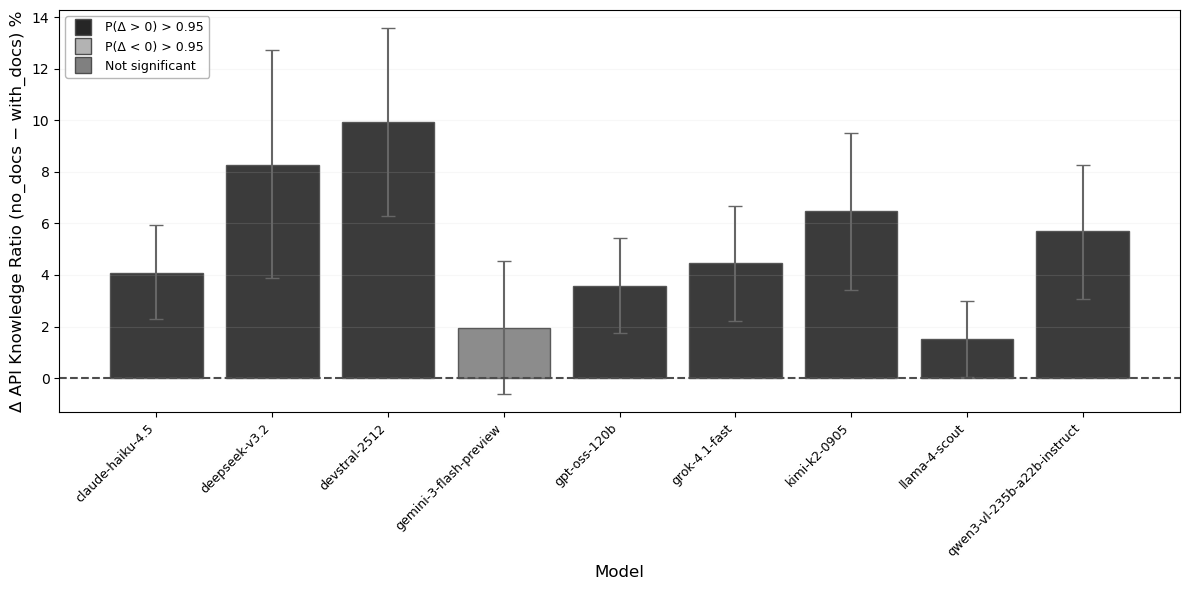


Dark bars: P(Δ > 0) > 0.95 (docs significantly reduce error proportion)
Light bars: P(Δ < 0) > 0.95 (docs significantly increase error proportion)
Medium bars: Not significant
Saved bootstrap run: b56674e7-bf32-41e0-89f6-e96fb12f4c2e
  Description: API Knowledge Error Ratio: no_docs vs with_docs
  Timestamp: 2026-02-20T19:13:42.411427
  Total runs in file: 51

Results saved: b56674e7-bf32-41e0-89f6-e96fb12f4c2e


In [10]:
# Run clustered Bayesian bootstrap for API knowledge error ratio delta per model
# Delta = ratio(no_docs) - ratio(with_docs)
# Positive delta means no_docs has higher API knowledge error ratio

bootstrap_results_ratio = {}

print("Bayesian Bootstrap: API Knowledge Error Ratio Delta (no_docs - with_docs)")
print("Positive delta = documentation REDUCES the proportion of API knowledge errors")
print("=" * 90)

for model in sorted(set(r["model"].split("/")[-1] for r in filtered_runs)):
    model_runs = [r for r in filtered_runs if r["model"].split("/")[-1] == model]
    
    no_docs_runs = [r for r in model_runs if not r.get("include_api_docs")]
    with_docs_runs = [r for r in model_runs if r.get("include_api_docs")]
    
    # Run clustered bootstrap (only uses shared tests)
    result = bayes_bootstrap_delta_clustered(
        group_a=no_docs_runs,
        group_b=with_docs_runs,
        statistic=weighted_api_knowledge_ratio,
        cluster_key="test_id",
        n_draws=100000,
        seed=42
    )
    
    if result:
        bootstrap_results_ratio[model] = result
        
        # Interpret: positive delta means no_docs has higher ratio
        # (i.e., documentation reduces API knowledge errors as % of total)
        direction = "DOCS REDUCE" if result["mean"] > 0 else "DOCS INCREASE"
        sig = "*" if (result["p_gt_0"] > 0.95 or result["p_lt_0"] > 0.95) else ""
        
        print(f"\n{model}:")
        print(f"  Delta (no_docs - with_docs): {result['mean']*100:.2f}% [{result['lo']*100:.2f}%, {result['hi']*100:.2f}%]")
        print(f"  P(delta > 0): {result['p_gt_0']:.3f}  |  P(delta < 0): {result['p_lt_0']:.3f}")
        print(f"  Clusters used: {result['n_clusters']} tests (n_a={result['n_a']}, n_b={result['n_b']})")
        print(f"  Interpretation: {direction} API knowledge error proportion {sig}")
    else:
        print(f"\n{model}: No shared tests, cannot compute delta")

# Summary visualization (grayscale-friendly)
print("\n" + "=" * 90)
print("Summary: Delta in API Knowledge Error Ratio (no_docs - with_docs)")

from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 6))

models = list(bootstrap_results_ratio.keys())
means = [bootstrap_results_ratio[m]["mean"] * 100 for m in models]
los = [bootstrap_results_ratio[m]["lo"] * 100 for m in models]
his = [bootstrap_results_ratio[m]["hi"] * 100 for m in models]
errors = [[m - l for m, l in zip(means, los)], [h - m for m, h in zip(means, his)]]

x = np.arange(len(models))

# Grayscale-friendly colors based on significance
colors = []
for model in models:
    p_gt = bootstrap_results_ratio[model]["p_gt_0"]
    p_lt = bootstrap_results_ratio[model]["p_lt_0"]
    if p_gt > 0.95:
        colors.append('0.15')  # dark = significant positive delta
    elif p_lt > 0.95:
        colors.append('0.7')   # light = significant negative delta
    else:
        colors.append('0.5')   # medium = not significant

bars = ax.bar(x, means, yerr=errors, capsize=5, color=colors, 
              edgecolor='0.3', alpha=0.9, ecolor='0.4')

ax.axhline(y=0, color='0.3', linestyle='--', linewidth=1.5)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Δ API Knowledge Ratio (no_docs − with_docs) %', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.15, color='0.8')

# Legend
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.15',
           markersize=12, markeredgecolor='0.3', markeredgewidth=1,
           label='P(Δ > 0) > 0.95', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.7',
           markersize=12, markeredgecolor='0.3', markeredgewidth=1,
           label='P(Δ < 0) > 0.95', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.5',
           markersize=12, markeredgecolor='0.3', markeredgewidth=1,
           label='Not significant', linestyle='None'),
]
ax.legend(handles=legend_elements, fontsize=9, loc='upper left',
          framealpha=0.95, edgecolor='0.7')

plt.tight_layout()
plt.savefig("api_knowledge_ratio_delta.pdf", bbox_inches='tight')
plt.show()

print("\nDark bars: P(Δ > 0) > 0.95 (docs significantly reduce error proportion)")
print("Light bars: P(Δ < 0) > 0.95 (docs significantly increase error proportion)")
print("Medium bars: Not significant")

# Save results
run_id_ratio = save_bootstrap_run(
    description="API Knowledge Error Ratio: no_docs vs with_docs",
    results=bootstrap_results_ratio,
    metadata={
        "statistic": "weighted_api_knowledge_ratio",
        "api_knowledge_errors": ["endpoint_selection", "parameter_misuse"],
        "comparison": "no_docs vs with_docs (ratio of API errors to total errors)",
        "bootstrap_method": "bayes_bootstrap_delta_clustered",
        "cluster_key": "test_id",
        "n_draws": 100000,
        "seed": 42,
        "interpretation": "positive delta = docs reduce API knowledge error proportion",
        "n_runs_analyzed": len(filtered_runs)
    }
)
print(f"\nResults saved: {run_id_ratio}")

Bayesian Bootstrap: API Knowledge Error ABSOLUTE RATE Delta (no_docs - with_docs)
Positive delta = documentation REDUCES the absolute rate of API knowledge errors

claude-haiku-4.5:
  Raw means: no_docs=0.367, with_docs=0.154
  Delta (no_docs - with_docs): 0.214 [0.126, 0.306]
  P(delta > 0): 1.000  |  P(delta < 0): 0.000
  Clusters used: 220 tests
  Interpretation: DOCS REDUCE absolute API knowledge errors *

deepseek-v3.2:
  Raw means: no_docs=0.341, with_docs=0.150
  Delta (no_docs - with_docs): 0.188 [0.107, 0.273]
  P(delta > 0): 1.000  |  P(delta < 0): 0.000
  Clusters used: 218 tests
  Interpretation: DOCS REDUCE absolute API knowledge errors *

devstral-2512:
  Raw means: no_docs=0.626, with_docs=0.198
  Delta (no_docs - with_docs): 0.428 [0.330, 0.529]
  P(delta > 0): 1.000  |  P(delta < 0): 0.000
  Clusters used: 222 tests
  Interpretation: DOCS REDUCE absolute API knowledge errors *

gemini-3-flash-preview:
  Raw means: no_docs=0.270, with_docs=0.158
  Delta (no_docs - with_

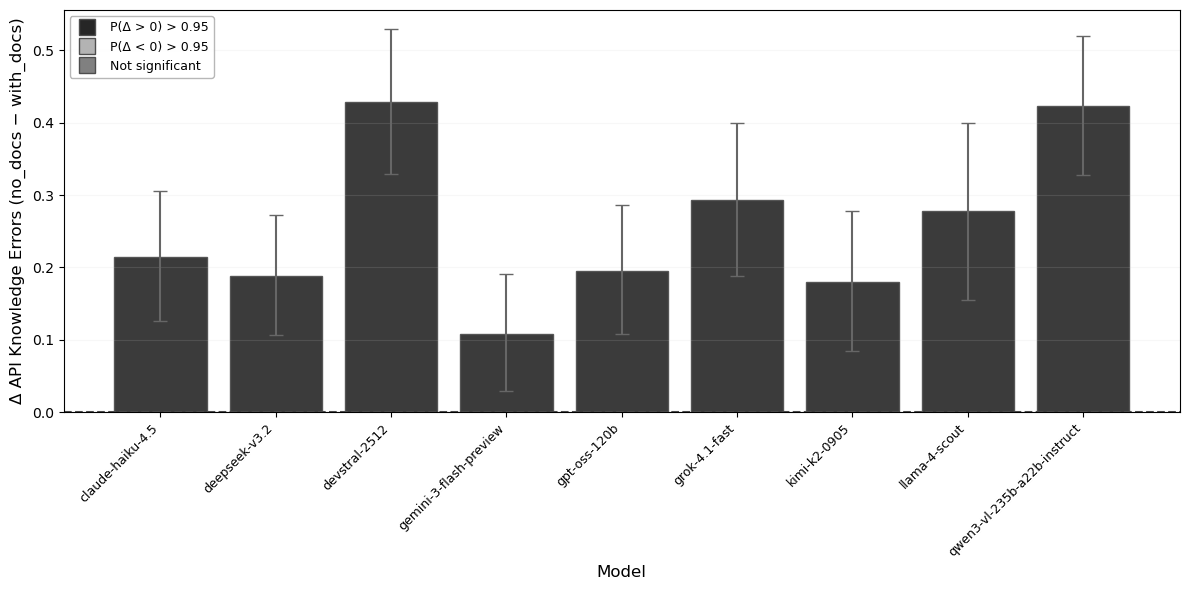


Dark bars: P(Δ > 0) > 0.95 (docs significantly reduce errors)
Light bars: P(Δ < 0) > 0.95 (docs significantly increase errors)
Medium bars: Not significant
Saved bootstrap run: fb56e69a-e767-4e6f-b834-88fe1227a394
  Description: API Knowledge Error Absolute Rate: no_docs vs with_docs
  Timestamp: 2026-02-20T19:14:40.132371
  Total runs in file: 52

Results saved: fb56e69a-e767-4e6f-b834-88fe1227a394


In [11]:
# Run clustered Bayesian bootstrap for API knowledge error ABSOLUTE RATE per model
# Delta = rate(no_docs) - rate(with_docs)
# Rate = API knowledge errors per test (not as proportion of total errors)
# Positive delta means no_docs has higher absolute rate of API knowledge errors

def weighted_api_knowledge_rate(runs: list[dict], weights: np.ndarray) -> float:
    """
    Compute weighted API knowledge error rate (absolute, not ratio).
    Rate = weighted mean of API knowledge errors per test.
    """
    api_knowledge = np.array([
        r.get("tool_use_errors", {}).get("endpoint_selection", 0) + 
        r.get("tool_use_errors", {}).get("parameter_misuse", 0) 
        for r in runs
    ])
    return np.sum(api_knowledge * weights)

bootstrap_results_absolute = {}

print("Bayesian Bootstrap: API Knowledge Error ABSOLUTE RATE Delta (no_docs - with_docs)")
print("Positive delta = documentation REDUCES the absolute rate of API knowledge errors")
print("=" * 90)

for model in sorted(set(r["model"].split("/")[-1] for r in filtered_runs)):
    model_runs = [r for r in filtered_runs if r["model"].split("/")[-1] == model]
    
    no_docs_runs = [r for r in model_runs if not r.get("include_api_docs")]
    with_docs_runs = [r for r in model_runs if r.get("include_api_docs")]
    
    # Run clustered bootstrap (only uses shared tests)
    result = bayes_bootstrap_delta_clustered(
        group_a=no_docs_runs,
        group_b=with_docs_runs,
        statistic=weighted_api_knowledge_rate,
        cluster_key="test_id",
        n_draws=100000,
        seed=42
    )
    
    if result:
        bootstrap_results_absolute[model] = result
        
        # Compute raw means for context
        no_docs_mean = np.mean([
            r.get("tool_use_errors", {}).get("endpoint_selection", 0) + 
            r.get("tool_use_errors", {}).get("parameter_misuse", 0) 
            for r in no_docs_runs
        ]) if no_docs_runs else 0
        with_docs_mean = np.mean([
            r.get("tool_use_errors", {}).get("endpoint_selection", 0) + 
            r.get("tool_use_errors", {}).get("parameter_misuse", 0) 
            for r in with_docs_runs
        ]) if with_docs_runs else 0
        
        direction = "DOCS REDUCE" if result["mean"] > 0 else "DOCS INCREASE"
        sig = "*" if (result["p_gt_0"] > 0.95 or result["p_lt_0"] > 0.95) else ""
        
        print(f"\n{model}:")
        print(f"  Raw means: no_docs={no_docs_mean:.3f}, with_docs={with_docs_mean:.3f}")
        print(f"  Delta (no_docs - with_docs): {result['mean']:.3f} [{result['lo']:.3f}, {result['hi']:.3f}]")
        print(f"  P(delta > 0): {result['p_gt_0']:.3f}  |  P(delta < 0): {result['p_lt_0']:.3f}")
        print(f"  Clusters used: {result['n_clusters']} tests")
        print(f"  Interpretation: {direction} absolute API knowledge errors {sig}")
    else:
        print(f"\n{model}: No shared tests, cannot compute delta")

# Summary visualization (grayscale-friendly)
print("\n" + "=" * 90)
print("Summary: Delta in API Knowledge Error ABSOLUTE RATE (no_docs - with_docs)")

from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 6))

models = list(bootstrap_results_absolute.keys())
means = [bootstrap_results_absolute[m]["mean"] for m in models]
los = [bootstrap_results_absolute[m]["lo"] for m in models]
his = [bootstrap_results_absolute[m]["hi"] for m in models]
errors = [[m - l for m, l in zip(means, los)], [h - m for m, h in zip(means, his)]]

x = np.arange(len(models))

# Grayscale-friendly colors based on significance
colors = []
for model in models:
    p_gt = bootstrap_results_absolute[model]["p_gt_0"]
    p_lt = bootstrap_results_absolute[model]["p_lt_0"]
    if p_gt > 0.95:
        colors.append('0.15')  # dark = significant positive delta
    elif p_lt > 0.95:
        colors.append('0.7')   # light = significant negative delta
    else:
        colors.append('0.5')   # medium = not significant

bars = ax.bar(x, means, yerr=errors, capsize=5, color=colors, 
              edgecolor='0.3', alpha=0.9, ecolor='0.4')

ax.axhline(y=0, color='0.3', linestyle='--', linewidth=1.5)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Δ API Knowledge Errors (no_docs − with_docs)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.15, color='0.8')

# Legend
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.15',
           markersize=12, markeredgecolor='0.3', markeredgewidth=1,
           label='P(Δ > 0) > 0.95', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.7',
           markersize=12, markeredgecolor='0.3', markeredgewidth=1,
           label='P(Δ < 0) > 0.95', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.5',
           markersize=12, markeredgecolor='0.3', markeredgewidth=1,
           label='Not significant', linestyle='None'),
]
ax.legend(handles=legend_elements, fontsize=9, loc='upper left',
          framealpha=0.95, edgecolor='0.7')

plt.tight_layout()
plt.savefig("api_knowledge_absolute_rate_delta.pdf", bbox_inches='tight')
plt.show()

print("\nDark bars: P(Δ > 0) > 0.95 (docs significantly reduce errors)")
print("Light bars: P(Δ < 0) > 0.95 (docs significantly increase errors)")
print("Medium bars: Not significant")

# Save results
run_id_abs = save_bootstrap_run(
    description="API Knowledge Error Absolute Rate: no_docs vs with_docs",
    results=bootstrap_results_absolute,
    metadata={
        "statistic": "weighted_api_knowledge_rate",
        "api_knowledge_errors": ["endpoint_selection", "parameter_misuse"],
        "comparison": "no_docs vs with_docs (absolute rate, not ratio)",
        "bootstrap_method": "bayes_bootstrap_delta_clustered",
        "cluster_key": "test_id",
        "n_draws": 100000,
        "seed": 42,
        "interpretation": "positive delta = docs reduce absolute API knowledge error count",
        "n_runs_analyzed": len(filtered_runs)
    }
)
print(f"\nResults saved: {run_id_abs}")

# Recovery strategies analysis

In [10]:
# Weighted recovery strategies by test_id
# Each test_id contributes equally regardless of how many runs it has

from collections import Counter

# Step 1: Count occurrences of each test_id
test_id_counts = Counter(run["test_id"] for run in filtered_runs)
print(f"Total unique test_ids: {len(test_id_counts)}")
print(f"Total runs: {len(filtered_runs)}")
print(f"Test_id count distribution: min={min(test_id_counts.values())}, max={max(test_id_counts.values())}, mean={sum(test_id_counts.values())/len(test_id_counts):.1f}")

# Step 2: Compute weight for each test_id (1 / count)
test_id_weights = {test_id: 1.0 / count for test_id, count in test_id_counts.items()}

# Step 3: Create weighted runs with only essential fields + weighted recovery strategies
recovery_strategy_keys = [
    "retry_same", "retry_modified_params", "switch_tool", "lookup_correct_value",
    "backtrack", "parse_error_message", "handle_ui_obstacle", "change_strategy",
    "break_into_steps", "verify_prerequisites", "skip_and_continue", "wait_and_retry",
    "use_fallback", "other_recovery_strategy", "no_recovery_attempted",
    "total_recovery_strategies"
]

weighted_recovery_runs = []
for run in filtered_runs:
    test_id = run["test_id"]
    weight = test_id_weights[test_id]
    
    # Extract essential identification fields
    weighted_run = {
        "run_id": run["run_id"],
        "test_id": test_id,
        "service": run["service"],
        "model": run["model"],
        "score": run["score"],  # base_score (0-100)
        "status": run["status"],
        "include_api_docs": run["include_api_docs"],
        "min_tool_calls": run["min_tool_calls"],  # for complexity level segmentation
        "weight": weight,  # store the weight for reference
    }
    
    # Weighted recovery strategies
    recovery_strategies = run.get("recovery_strategies", {})
    weighted_recovery = {}
    for key in recovery_strategy_keys:
        original_value = recovery_strategies.get(key, 0)
        weighted_recovery[key] = original_value * weight
        weighted_recovery[f"{key}_raw"] = original_value  # keep raw for reference
    
    weighted_run["recovery_strategies"] = weighted_recovery
    weighted_recovery_runs.append(weighted_run)

print(f"\nCreated {len(weighted_recovery_runs)} weighted recovery runs")

# Verify weighting: sum of weights per test_id should equal 1
test_id_weight_sums = {}
for run in weighted_recovery_runs:
    tid = run["test_id"]
    test_id_weight_sums[tid] = test_id_weight_sums.get(tid, 0) + run["weight"]

# Check that all test_ids have weight sum of 1
weight_sum_values = list(test_id_weight_sums.values())
print(f"Weight sum per test_id: min={min(weight_sum_values):.4f}, max={max(weight_sum_values):.4f}")
print("✓ Each test_id contributes equally (weight sum = 1.0)")

# Show sample
print("\nSample weighted run:")
sample = weighted_recovery_runs[0]
print(f"  test_id: {sample['test_id'][:8]}...")
print(f"  weight: {sample['weight']:.4f}")
print(f"  min_tool_calls: {sample['min_tool_calls']}")
print(f"  recovery_strategies (weighted):")
for key in ["retry_same", "parse_error_message", "total_recovery_strategies"]:
    print(f"    {key}: {sample['recovery_strategies'][key]:.4f} (raw: {sample['recovery_strategies'][f'{key}_raw']})")

Total unique test_ids: 222
Total runs: 3955
Test_id count distribution: min=16, max=18, mean=17.8

Created 3955 weighted recovery runs
Weight sum per test_id: min=1.0000, max=1.0000
✓ Each test_id contributes equally (weight sum = 1.0)

Sample weighted run:
  test_id: 2443b5cf...
  weight: 0.0556
  min_tool_calls: 1
  recovery_strategies (weighted):
    retry_same: 0.0000 (raw: 0)
    parse_error_message: 0.0000 (raw: 0)
    total_recovery_strategies: 0.0000 (raw: 0)


In [11]:
# Weighted recovery strategies by test_id
# Each test_id contributes equally regardless of how many runs it has
# Only include runs where recovery was actually attempted (total_recovery_strategies > 0)
# Cluster key: (test_id, include_api_docs) to treat each experimental condition as a unit

from collections import Counter

# Step 1: Filter to runs with at least one recovery strategy used
runs_with_recovery = [
    run for run in filtered_runs 
    if run.get("recovery_strategies", {}).get("total_recovery_strategies", 0) > 0
]

print(f"Total runs in filtered_runs: {len(filtered_runs)}")
print(f"Runs with recovery strategies used: {len(runs_with_recovery)}")
print(f"Runs excluded (no recovery attempted): {len(filtered_runs) - len(runs_with_recovery)}")

# Step 2: Create composite cluster key (test_id + include_api_docs)
# This treats each (test, docs_condition) pair as a separate experimental unit
for run in runs_with_recovery:
    run["cluster_key"] = f"{run['test_id']}_{run['include_api_docs']}"

# Step 3: Count occurrences of each cluster_key in filtered set
cluster_key_counts = Counter(run["cluster_key"] for run in runs_with_recovery)
print(f"\nUnique cluster keys (test_id × docs): {len(cluster_key_counts)}")
print(f"Cluster key count distribution: min={min(cluster_key_counts.values())}, max={max(cluster_key_counts.values())}, mean={sum(cluster_key_counts.values())/len(cluster_key_counts):.1f}")

# Also show test_id counts for comparison
test_id_counts = Counter(run["test_id"] for run in runs_with_recovery)
print(f"Unique test_ids: {len(test_id_counts)}")

# Step 4: Compute weight for each cluster_key (1 / count)
cluster_key_weights = {ck: 1.0 / count for ck, count in cluster_key_counts.items()}

# Step 5: Create weighted runs with only essential fields + weighted recovery strategies
recovery_strategy_keys = [
    "retry_same", "retry_modified_params", "switch_tool", "lookup_correct_value",
    "backtrack", "parse_error_message", "handle_ui_obstacle", "change_strategy",
    "break_into_steps", "verify_prerequisites", "skip_and_continue", "wait_and_retry",
    "use_fallback", "other_recovery_strategy", "no_recovery_attempted",
    "total_recovery_strategies"
]

weighted_recovery_runs = []
for run in runs_with_recovery:
    cluster_key = run["cluster_key"]
    weight = cluster_key_weights[cluster_key]
    
    # Extract essential identification fields
    weighted_run = {
        "run_id": run["run_id"],
        "test_id": run["test_id"],
        "cluster_key": cluster_key,  # Composite key for clustering
        "service": run["service"],
        "model": run["model"],
        "score": run["score"],  # base_score (0-100)
        "status": run["status"],
        "include_api_docs": run["include_api_docs"],
        "min_tool_calls": run["min_tool_calls"],  # for complexity level segmentation
        "weight": weight,  # store the weight for reference
    }
    
    # Weighted recovery strategies
    recovery_strategies = run.get("recovery_strategies", {})
    weighted_recovery = {}
    for key in recovery_strategy_keys:
        original_value = recovery_strategies.get(key, 0)
        weighted_recovery[key] = original_value * weight
        weighted_recovery[f"{key}_raw"] = original_value  # keep raw for reference
    
    weighted_run["recovery_strategies"] = weighted_recovery
    weighted_recovery_runs.append(weighted_run)

print(f"\nCreated {len(weighted_recovery_runs)} weighted recovery runs")

# Verify weighting: sum of weights per cluster_key should equal 1
cluster_key_weight_sums = {}
for run in weighted_recovery_runs:
    ck = run["cluster_key"]
    cluster_key_weight_sums[ck] = cluster_key_weight_sums.get(ck, 0) + run["weight"]

# Check that all cluster_keys have weight sum of 1
weight_sum_values = list(cluster_key_weight_sums.values())
print(f"Weight sum per cluster_key: min={min(weight_sum_values):.4f}, max={max(weight_sum_values):.4f}")
print("✓ Each (test_id, include_api_docs) pair contributes equally (weight sum = 1.0)")

# Show sample
print("\nSample weighted run:")
sample = weighted_recovery_runs[0]
print(f"  test_id: {sample['test_id'][:8]}...")
print(f"  cluster_key: {sample['cluster_key'][:20]}...")
print(f"  include_api_docs: {sample['include_api_docs']}")
print(f"  weight: {sample['weight']:.4f}")
print(f"  min_tool_calls: {sample['min_tool_calls']}")
print(f"  status: {sample['status']}")

Total runs in filtered_runs: 3955
Runs with recovery strategies used: 3625
Runs excluded (no recovery attempted): 330

Unique cluster keys (test_id × docs): 440
Cluster key count distribution: min=1, max=9, mean=8.2
Unique test_ids: 221

Created 3625 weighted recovery runs
Weight sum per cluster_key: min=1.0000, max=1.0000
✓ Each (test_id, include_api_docs) pair contributes equally (weight sum = 1.0)

Sample weighted run:
  test_id: e4494bce...
  cluster_key: e4494bce-7101-5ec5-b...
  include_api_docs: True
  weight: 0.1429
  min_tool_calls: 2
  status: passed


In [12]:
# Save/Load Bootstrap Results (to avoid recomputation)
import json
import os
from datetime import datetime

BOOTSTRAP_CACHE_DIR = "bootstrap_cache"

def save_bootstrap_results(results: dict, name: str, metadata: dict = None) -> str:
    """
    Save bootstrap results to a JSON file for later reuse.
    
    Args:
        results: Dict of {strategy: bootstrap_result_dict}
        name: Descriptive name for this result set (used as filename)
        metadata: Optional metadata to save alongside results
    
    Returns:
        Path to saved file
    """
    os.makedirs(BOOTSTRAP_CACHE_DIR, exist_ok=True)
    
    # Sanitize name for filename
    safe_name = name.replace(" ", "_").replace("/", "-").lower()
    filepath = os.path.join(BOOTSTRAP_CACHE_DIR, f"{safe_name}.json")
    
    data = {
        "name": name,
        "timestamp": datetime.now().isoformat(),
        "metadata": metadata or {},
        "results": results
    }
    
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"Saved bootstrap results to: {filepath}")
    return filepath


def load_bootstrap_results(name: str) -> dict | None:
    """
    Load bootstrap results from cache.
    
    Args:
        name: The name used when saving (or filename without .json)
    
    Returns:
        Dict with keys: name, timestamp, metadata, results
        Or None if file not found
    """
    safe_name = name.replace(" ", "_").replace("/", "-").lower()
    filepath = os.path.join(BOOTSTRAP_CACHE_DIR, f"{safe_name}.json")
    
    if not os.path.exists(filepath):
        print(f"Cache not found: {filepath}")
        return None
    
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    print(f"Loaded bootstrap results from: {filepath}")
    print(f"  Timestamp: {data['timestamp']}")
    print(f"  Strategies: {len(data['results'])}")
    return data


def get_or_compute_bootstrap(
    name: str,
    compute_fn: callable,
    force_recompute: bool = False
) -> dict:
    """
    Load cached results if available, otherwise compute and cache.
    
    Args:
        name: Cache key/filename
        compute_fn: Function that returns (results_dict, metadata_dict)
        force_recompute: If True, ignore cache and recompute
    
    Returns:
        The results dict
    """
    if not force_recompute:
        cached = load_bootstrap_results(name)
        if cached is not None:
            return cached["results"]
    
    print(f"Computing bootstrap results for: {name}")
    results, metadata = compute_fn()
    save_bootstrap_results(results, name, metadata)
    return results


# List available cached results
def list_cached_bootstrap():
    """List all cached bootstrap result files."""
    if not os.path.exists(BOOTSTRAP_CACHE_DIR):
        print("No cache directory found")
        return []
    
    files = [f for f in os.listdir(BOOTSTRAP_CACHE_DIR) if f.endswith('.json')]
    print(f"Cached bootstrap results ({len(files)}):")
    for f in sorted(files):
        filepath = os.path.join(BOOTSTRAP_CACHE_DIR, f)
        with open(filepath) as fh:
            data = json.load(fh)
        print(f"  - {f}: {data['name']} ({data['timestamp'][:10]})")
    return files

print("Bootstrap cache functions loaded:")
print("  - save_bootstrap_results(results, name, metadata)")
print("  - load_bootstrap_results(name)")
print("  - get_or_compute_bootstrap(name, compute_fn, force_recompute)")
print("  - list_cached_bootstrap()")


Bootstrap cache functions loaded:
  - save_bootstrap_results(results, name, metadata)
  - load_bootstrap_results(name)
  - get_or_compute_bootstrap(name, compute_fn, force_recompute)
  - list_cached_bootstrap()


MEDIAN SPLIT: Top 4 vs Bottom 5 (including llama)
Top 4 models: ['deepseek/deepseek-v3.2', 'mistralai/devstral-2512', 'moonshotai/kimi-k2-0905', 'qwen/qwen3-vl-235b-a22b-instruct']
Bottom 5 models: ['anthropic/claude-haiku-4.5', 'google/gemini-3-flash-preview', 'meta-llama/llama-4-scout', 'openai/gpt-oss-120b', 'x-ai/grok-4.1-fast']

Runs in top 4: 1679
Runs in bottom 5: 1946

Filtering strategies (>= 5% usage in at least one group):
Strategy                       Top 4   Bottom 5    Include
------------------------------------------------------------
retry_same                      7.0%      16.5%          ✓
retry_modified_params          45.6%      53.5%          ✓
switch_tool                     7.1%       8.1%          ✓
lookup_correct_value           83.3%      76.7%          ✓
backtrack                      17.6%      22.1%          ✓
parse_error_message            42.0%      49.9%          ✓
handle_ui_obstacle              0.0%       0.0%          ✗
change_strategy              

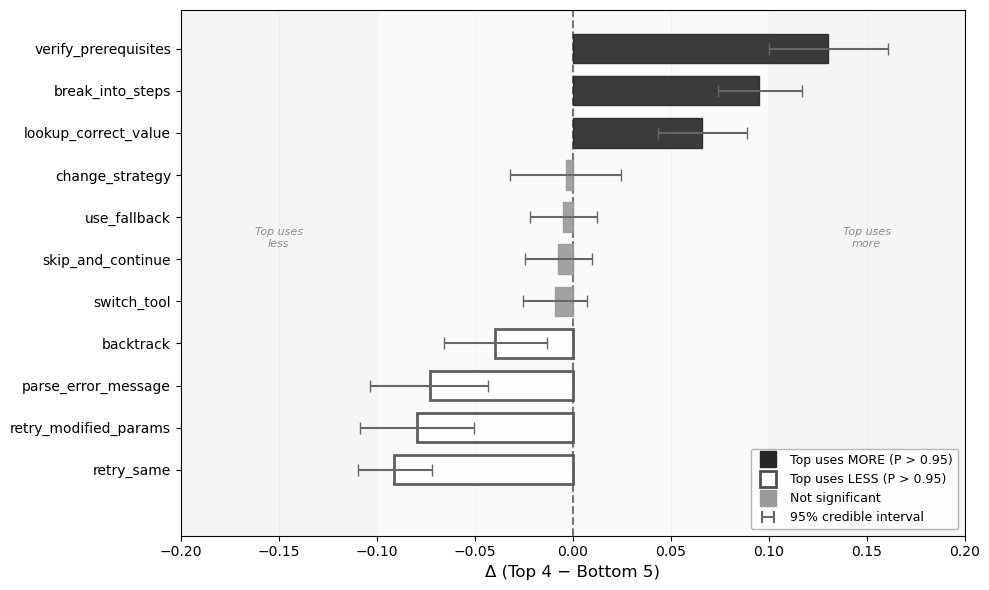

Saved bootstrap run: 0d8e1dce-f8ad-4855-bdb8-97906aa589e5
  Description: Recovery Strategy Delta: Top 4 vs Bottom 5 (median split, including llama)
  Timestamp: 2026-02-09T13:05:48.239918
  Total runs in file: 48

Results saved: 0d8e1dce-f8ad-4855-bdb8-97906aa589e5


In [ ]:
# Bayesian Bootstrap: Median Split - Top 4 vs Bottom 5 (INCLUDING llama)
# Top 4: deepseek, devstral, qwen, kimi
# Bottom 5: grok, gemini, gpt-oss, claude-haiku, llama
# Filter: Only strategies with >= 5% usage in at least one group

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from bayes_bootstrap import bayes_bootstrap_delta_paired_clustered, save_bootstrap_run


MIN_USAGE_THRESHOLD = 0.05  # 5% minimum usage in at least one group

all_strategies = [
    "retry_same", "retry_modified_params", "switch_tool", "lookup_correct_value",
    "backtrack", "parse_error_message", "handle_ui_obstacle", "change_strategy",
    "break_into_steps", "verify_prerequisites", "skip_and_continue", "wait_and_retry",
    "use_fallback", "other_recovery_strategy"
]

# Top 4 models (median split - top half)
top_4_keywords = ["deepseek", "devstral", "qwen", "kimi"]

def is_top_4_model(model_name):
    model_lower = model_name.lower()
    return any(keyword in model_lower for keyword in top_4_keywords)

all_models = set(r["model"] for r in weighted_recovery_runs)
top_4_models = {m for m in all_models if is_top_4_model(m)}
bottom_5_models = all_models - top_4_models

print("MEDIAN SPLIT: Top 4 vs Bottom 5 (including llama)")
print("=" * 60)
print(f"Top 4 models: {sorted(top_4_models)}")
print(f"Bottom 5 models: {sorted(bottom_5_models)}")

top_4_runs = [r for r in weighted_recovery_runs if r["model"] in top_4_models]
bottom_5_runs = [r for r in weighted_recovery_runs if r["model"] in bottom_5_models]

print(f"\nRuns in top 4: {len(top_4_runs)}")
print(f"Runs in bottom 5: {len(bottom_5_runs)}")

# Calculate usage rates to filter strategies
def calc_usage_rate(runs, strategy):
    total = len(runs)
    if total == 0:
        return 0
    used = sum(1 for r in runs if r["recovery_strategies"].get(f"{strategy}_raw", 0) == 1)
    return used / total

print(f"\nFiltering strategies (>= {MIN_USAGE_THRESHOLD*100:.0f}% usage in at least one group):")
print(f"{'Strategy':<25} {'Top 4':>10} {'Bottom 5':>10} {'Include':>10}")
print("-" * 60)

strategies_to_analyze = []
excluded_strategies = []
for strategy in all_strategies:
    top_rate = calc_usage_rate(top_4_runs, strategy)
    bottom_rate = calc_usage_rate(bottom_5_runs, strategy)
    include = top_rate >= MIN_USAGE_THRESHOLD or bottom_rate >= MIN_USAGE_THRESHOLD
    status = "✓" if include else "✗"
    print(f"{strategy:<25} {top_rate*100:>9.1f}% {bottom_rate*100:>9.1f}% {status:>10}")
    if include:
        strategies_to_analyze.append(strategy)
    else:
        excluded_strategies.append(strategy)

print(f"\nIncluded: {len(strategies_to_analyze)} strategies")
print(f"Excluded: {len(excluded_strategies)} strategies ({excluded_strategies})")

# Statistic factory
def make_strategy_statistic(strategy: str):
    def weighted_strategy_rate(runs: list[dict], weights: np.ndarray) -> float:
        values = np.array([r["recovery_strategies"].get(f"{strategy}_raw", 0) for r in runs])
        return np.sum(values * weights)
    return weighted_strategy_rate

# Run bootstrap only on filtered strategies (with caching)
CACHE_NAME = "top4_vs_bottom5_incl_llama"
FORCE_RECOMPUTE = False  # Set to True to recompute even if cached

def compute_bootstrap_top4_incl_llama():
    """Compute bootstrap results for Top 4 vs Bottom 5 (incl llama)."""
    print("Running Bayesian bootstrap on filtered strategies...")
    print("-" * 60)
    
    results = {}
    for strategy in strategies_to_analyze:
        statistic_fn = make_strategy_statistic(strategy)
        result = bayes_bootstrap_delta_paired_clustered(
            group_a=top_4_runs,
            group_b=bottom_5_runs,
            statistic=statistic_fn,
            cluster_key="cluster_key",
            n_draws=10000,
            seed=42
        )
        results[strategy] = result
        
        sig = ""
        if result['p_gt_0'] > 0.95:
            sig = "*** TOP MORE"
        elif result['p_lt_0'] > 0.95:
            sig = "*** TOP LESS"
        print(f"  {strategy:<25} Δ={result['mean']:+.4f} P(Δ>0)={result['p_gt_0']:.3f} {sig}")
    
    metadata = {
        "split_method": "median_split_top4_vs_bottom5",
        "top_models": sorted(top_4_models),
        "bottom_models": sorted(bottom_5_models),
        "includes_llama": True,
        "min_usage_threshold": MIN_USAGE_THRESHOLD,
        "strategies_analyzed": strategies_to_analyze,
        "n_draws": 10000
    }
    return results, metadata

# Load from cache or compute
bootstrap_results_top4_incl_llama = get_or_compute_bootstrap(
    CACHE_NAME, 
    compute_bootstrap_top4_incl_llama,
    force_recompute=FORCE_RECOMPUTE
)

# Results table
print("\n" + "=" * 90)
print("BOOTSTRAP RESULTS: Top 4 vs Bottom 5 (incl. llama)")
print("=" * 90)
print(f"{'Strategy':<25} {'Delta':>10} {'95% CI':>22} {'P(Δ>0)':>10} {'Sig':>8}")
print("-" * 90)

sorted_results = sorted(bootstrap_results_top4_incl_llama.items(), key=lambda x: x[1]['mean'], reverse=True)
for strategy, res in sorted_results:
    ci_str = f"[{res['lo']:+.4f}, {res['hi']:+.4f}]"
    if res['p_gt_0'] > 0.95:
        sig = "✓✓✓"
    elif res['p_lt_0'] > 0.95:
        sig = "✗✗✗"
    elif res['p_gt_0'] > 0.90 or res['p_lt_0'] > 0.90:
        sig = "*"
    else:
        sig = ""
    print(f"{strategy:<25} {res['mean']:>+.4f} {ci_str:>22} {res['p_gt_0']:>10.3f} {sig:>8}")

# Forest plot (grayscale-friendly)
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, max(6, len(strategies_to_analyze) * 0.5)))

# Background shading for effect zones (gradient: edges slightly bright, middle brightest, inner bright)
ax.axvspan(-0.25, -0.10, color='0.96', zorder=0)   # outer negative (slightly bright)
ax.axvspan(-0.10, -0.03, color='0.98', zorder=0)   # middle negative (brightest)
ax.axvspan(-0.03, 0, color='0.98', zorder=0)       # inner negative (bright)
ax.axvspan(0, 0.03, color='0.98', zorder=0)        # inner positive (bright)
ax.axvspan(0.03, 0.10, color='0.98', zorder=0)     # middle positive (brightest)
ax.axvspan(0.10, 0.25, color='0.96', zorder=0)     # outer positive (slightly bright)

sorted_for_plot = sorted(bootstrap_results_top4_incl_llama.items(), key=lambda x: x[1]['mean'])
strategies_plot = [s for s, _ in sorted_for_plot]
means = [r['mean'] for _, r in sorted_for_plot]
los = [r['lo'] for _, r in sorted_for_plot]
his = [r['hi'] for _, r in sorted_for_plot]

y_pos = np.arange(len(strategies_plot))

xerr_low = [m - l for m, l in zip(means, los)]
xerr_high = [h - m for m, h in zip(means, his)]

# Plot bars with grayscale styling
for idx, (strategy, r) in enumerate(sorted_for_plot):
    if r['p_gt_0'] > 0.95:
        # Top uses MORE: filled dark
        facecolor = '0.15'
        edgecolor = '0.15'
        linewidth = 1
    elif r['p_lt_0'] > 0.95:
        # Top uses LESS: open (white fill, dark edge)
        facecolor = 'white'
        edgecolor = '0.3'
        linewidth = 2
    else:
        # Not significant: medium gray
        facecolor = '0.6'
        edgecolor = '0.6'
        linewidth = 1
    
    ax.barh(y_pos[idx], means[idx], xerr=[[xerr_low[idx]], [xerr_high[idx]]], 
            color=facecolor, edgecolor=edgecolor, linewidth=linewidth,
            alpha=0.9, capsize=4, ecolor='0.4', height=0.7, zorder=2)

ax.axvline(x=0, color='0.3', linestyle='--', linewidth=1.5, alpha=0.8, zorder=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(strategies_plot, fontsize=10)
ax.set_xlabel('Δ (Top 4 − Bottom 5)', fontsize=12)

# Zone labels - centered vertically in middle of plot
mid_y = len(strategies_plot) / 2
ax.text(0.15, mid_y, 'Top uses\nmore', fontsize=8, color='0.55', 
        ha='center', va='center', style='italic')
ax.text(-0.15, mid_y, 'Top uses\nless', fontsize=8, color='0.55', 
        ha='center', va='center', style='italic')

# Grayscale-friendly legend with actual error bar representation
from matplotlib.lines import Line2D

# Create an invisible errorbar off-plot for legend (proper |--| pattern)
eb_legend = ax.errorbar([-1], [-1], xerr=[0.02], fmt='none', 
                        ecolor='0.4', elinewidth=1.5, capsize=4, capthick=1.5,
                        label='95% credible interval')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.15',
           markersize=12, markeredgecolor='0.15', markeredgewidth=1,
           label='Top uses MORE (P > 0.95)', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='white',
           markersize=12, markeredgecolor='0.3', markeredgewidth=2,
           label='Top uses LESS (P > 0.95)', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.6',
           markersize=12, markeredgecolor='0.6', markeredgewidth=1,
           label='Not significant', linestyle='None'),
    eb_legend,  # Real error bar with proper caps
]

ax.legend(handles=legend_elements, fontsize=9, loc='lower right',
          framealpha=0.95, edgecolor='0.7')

ax.grid(True, axis='x', alpha=0.15, color='0.8')
ax.set_xlim(-0.20, 0.20)

plt.tight_layout()
plt.savefig("recovery_bootstrap_top4_vs_bottom5_incl_llama.pdf", bbox_inches='tight')
plt.show()

# Save results
run_id_incl = save_bootstrap_run(
    description="Recovery Strategy Delta: Top 4 vs Bottom 5 (median split, including llama)",
    results=bootstrap_results_top4_incl_llama,
    metadata={
        "split_method": "median_split_top4_vs_bottom5",
        "top_models": sorted(top_4_models),
        "bottom_models": sorted(bottom_5_models),
        "includes_llama": True,
        "min_usage_threshold": MIN_USAGE_THRESHOLD,
        "strategies_analyzed": strategies_to_analyze,
        "strategies_excluded": excluded_strategies,
        "n_draws": 10000,
        "seed": 42
    }
)
print(f"\nResults saved: {run_id_incl}")

In [15]:
print("cluster_key" in weighted_recovery_runs[0])


True


MEDIAN SPLIT: Top 4 vs Bottom 4 (excluding llama outlier)
Top 4 models: ['deepseek/deepseek-v3.2', 'mistralai/devstral-2512', 'moonshotai/kimi-k2-0905', 'qwen/qwen3-vl-235b-a22b-instruct']
Bottom 4 models: ['anthropic/claude-haiku-4.5', 'google/gemini-3-flash-preview', 'openai/gpt-oss-120b', 'x-ai/grok-4.1-fast']
Excluded (outlier): ['meta-llama/llama-4-scout']

Runs in top 4: 1679
Runs in bottom 4: 1564

Filtering strategies (>= 5% usage in at least one group):
Strategy                       Top 4   Bottom 4    Include
------------------------------------------------------------
retry_same                      7.0%      10.5%          ✓
retry_modified_params          45.6%      48.0%          ✓
switch_tool                     7.1%       6.3%          ✓
lookup_correct_value           83.3%      80.4%          ✓
backtrack                      17.6%      19.5%          ✓
parse_error_message            42.0%      44.1%          ✓
handle_ui_obstacle              0.0%       0.0%          ✗


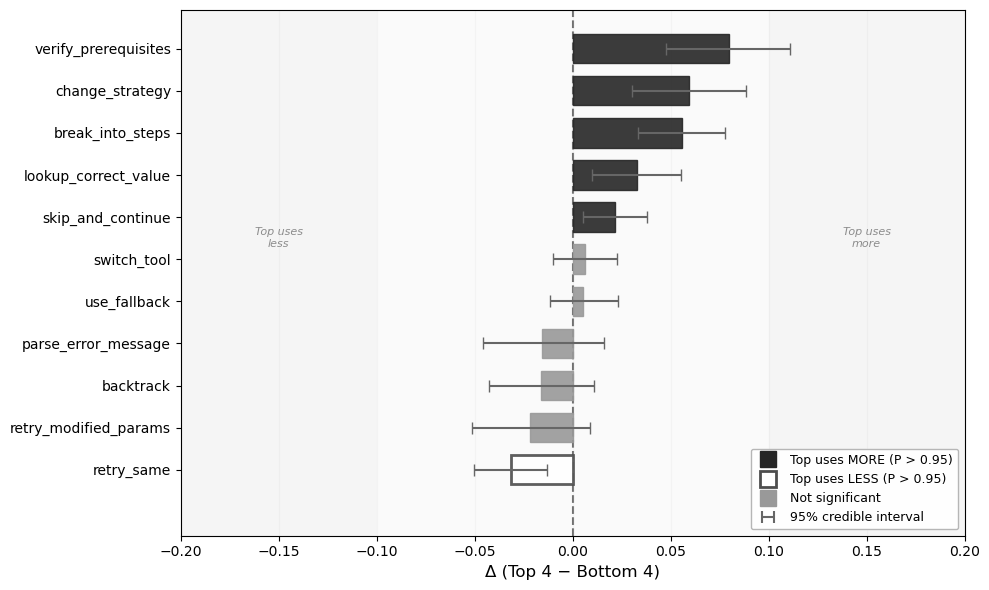

Saved bootstrap run: ad81ff57-25e1-4e3a-956f-d409cd15dd36
  Description: Recovery Strategy Delta: Top 4 vs Bottom 4 (median split, excluding llama outlier)
  Timestamp: 2026-02-09T13:07:49.743370
  Total runs in file: 49

Results saved: ad81ff57-25e1-4e3a-956f-d409cd15dd36

SIGNIFICANT FINDINGS (Top 4 vs Bottom 4, excl. llama)

Strategies MORE common in top 4 models (P>0.95):
  ✓ verify_prerequisites: Δ=+0.0796 [+0.0478, +0.1112]
  ✓ change_strategy: Δ=+0.0593 [+0.0305, +0.0887]
  ✓ break_into_steps: Δ=+0.0558 [+0.0334, +0.0780]
  ✓ lookup_correct_value: Δ=+0.0329 [+0.0101, +0.0555]
  ✓ skip_and_continue: Δ=+0.0218 [+0.0055, +0.0378]

Strategies LESS common in top 4 models (P>0.95):
  ✗ retry_same: Δ=-0.0317 [-0.0502, -0.0130]


In [ ]:
# Bayesian Bootstrap: Median Split - Top 4 vs Bottom 4 (EXCLUDING llama outlier)
# Top 4: deepseek, devstral, qwen, kimi
# Bottom 4: grok, gemini, gpt-oss, claude-haiku
# Filter: Only strategies with >= 5% usage in at least one group

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from bayes_bootstrap import bayes_bootstrap_delta_paired_clustered, save_bootstrap_run

MIN_USAGE_THRESHOLD = 0.05  # 5% minimum usage in at least one group

all_strategies = [
    "retry_same", "retry_modified_params", "switch_tool", "lookup_correct_value",
    "backtrack", "parse_error_message", "handle_ui_obstacle", "change_strategy",
    "break_into_steps", "verify_prerequisites", "skip_and_continue", "wait_and_retry",
    "use_fallback", "other_recovery_strategy"
]

# Top 4 models
top_4_keywords = ["deepseek", "devstral", "qwen", "kimi"]
exclude_keywords = ["llama"]

def is_top_4_model(model_name):
    model_lower = model_name.lower()
    return any(keyword in model_lower for keyword in top_4_keywords)

def is_excluded(model_name):
    model_lower = model_name.lower()
    return any(keyword in model_lower for keyword in exclude_keywords)

all_models = set(r["model"] for r in weighted_recovery_runs)
top_4_models = {m for m in all_models if is_top_4_model(m)}
excluded_models = {m for m in all_models if is_excluded(m)}
bottom_4_models = all_models - top_4_models - excluded_models

print("MEDIAN SPLIT: Top 4 vs Bottom 4 (excluding llama outlier)")
print("=" * 60)
print(f"Top 4 models: {sorted(top_4_models)}")
print(f"Bottom 4 models: {sorted(bottom_4_models)}")
print(f"Excluded (outlier): {sorted(excluded_models)}")

top_4_runs = [r for r in weighted_recovery_runs if r["model"] in top_4_models]
bottom_4_runs = [r for r in weighted_recovery_runs if r["model"] in bottom_4_models]

print(f"\nRuns in top 4: {len(top_4_runs)}")
print(f"Runs in bottom 4: {len(bottom_4_runs)}")

# Calculate usage rates to filter strategies
def calc_usage_rate(runs, strategy):
    total = len(runs)
    if total == 0:
        return 0
    used = sum(1 for r in runs if r["recovery_strategies"].get(f"{strategy}_raw", 0) == 1)
    return used / total

print(f"\nFiltering strategies (>= {MIN_USAGE_THRESHOLD*100:.0f}% usage in at least one group):")
print(f"{'Strategy':<25} {'Top 4':>10} {'Bottom 4':>10} {'Include':>10}")
print("-" * 60)

strategies_to_analyze = []
excluded_strategies = []
for strategy in all_strategies:
    top_rate = calc_usage_rate(top_4_runs, strategy)
    bottom_rate = calc_usage_rate(bottom_4_runs, strategy)
    include = top_rate >= MIN_USAGE_THRESHOLD or bottom_rate >= MIN_USAGE_THRESHOLD
    status = "✓" if include else "✗"
    print(f"{strategy:<25} {top_rate*100:>9.1f}% {bottom_rate*100:>9.1f}% {status:>10}")
    if include:
        strategies_to_analyze.append(strategy)
    else:
        excluded_strategies.append(strategy)

print(f"\nIncluded: {len(strategies_to_analyze)} strategies")
print(f"Excluded: {len(excluded_strategies)} strategies ({excluded_strategies})")

# Statistic factory
def make_strategy_statistic(strategy: str):
    def weighted_strategy_rate(runs: list[dict], weights: np.ndarray) -> float:
        values = np.array([r["recovery_strategies"].get(f"{strategy}_raw", 0) for r in runs])
        return np.sum(values * weights)
    return weighted_strategy_rate

# Run bootstrap only on filtered strategies (with caching)
CACHE_NAME = "top4_vs_bottom4_excl_llama"
FORCE_RECOMPUTE = False  # Set to True to recompute even if cached

def compute_bootstrap_top4_excl_llama():
    """Compute bootstrap results for Top 4 vs Bottom 4 (excl llama)."""
    print("Running Bayesian bootstrap on filtered strategies...")
    print("-" * 60)
    
    results = {}
    for strategy in strategies_to_analyze:
        statistic_fn = make_strategy_statistic(strategy)
        result = bayes_bootstrap_delta_paired_clustered(
            group_a=top_4_runs,
            group_b=bottom_4_runs,
            statistic=statistic_fn,
            cluster_key="cluster_key",
            n_draws=10000,
            seed=42
        )
        results[strategy] = result
        
        sig = ""
        if result['p_gt_0'] > 0.95:
            sig = "*** TOP MORE"
        elif result['p_lt_0'] > 0.95:
            sig = "*** TOP LESS"
        print(f"  {strategy:<25} Δ={result['mean']:+.4f} P(Δ>0)={result['p_gt_0']:.3f} {sig}")
    
    metadata = {
        "split_method": "median_split_top4_vs_bottom4",
        "top_models": sorted(top_4_models),
        "bottom_models": sorted(bottom_4_models),
        "excluded_models": sorted(excluded_models),
        "exclusion_reason": "llama excluded as statistical outlier",
        "includes_llama": False,
        "min_usage_threshold": MIN_USAGE_THRESHOLD,
        "strategies_analyzed": strategies_to_analyze,
        "n_draws": 10000
    }
    return results, metadata

# Load from cache or compute
bootstrap_results_top4_excl_llama = get_or_compute_bootstrap(
    CACHE_NAME, 
    compute_bootstrap_top4_excl_llama,
    force_recompute=FORCE_RECOMPUTE
)

# Results table
print("\n" + "=" * 90)
print("BOOTSTRAP RESULTS: Top 4 vs Bottom 4 (excl. llama)")
print("=" * 90)
print(f"{'Strategy':<25} {'Delta':>10} {'95% CI':>22} {'P(Δ>0)':>10} {'Sig':>8}")
print("-" * 90)

sorted_results = sorted(bootstrap_results_top4_excl_llama.items(), key=lambda x: x[1]['mean'], reverse=True)
for strategy, res in sorted_results:
    ci_str = f"[{res['lo']:+.4f}, {res['hi']:+.4f}]"
    if res['p_gt_0'] > 0.95:
        sig = "✓✓✓"
    elif res['p_lt_0'] > 0.95:
        sig = "✗✗✗"
    elif res['p_gt_0'] > 0.90 or res['p_lt_0'] > 0.90:
        sig = "*"
    else:
        sig = ""
    print(f"{strategy:<25} {res['mean']:>+.4f} {ci_str:>22} {res['p_gt_0']:>10.3f} {sig:>8}")

# Forest plot (grayscale-friendly)
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, max(6, len(strategies_to_analyze) * 0.5)))

# Background shading for effect zones (gradient: edges slightly bright, middle brightest, inner bright)
ax.axvspan(-0.25, -0.10, color='0.96', zorder=0)   # outer negative (slightly bright)
ax.axvspan(-0.10, -0.03, color='0.98', zorder=0)   # middle negative (brightest)
ax.axvspan(-0.03, 0, color='0.98', zorder=0)       # inner negative (bright)
ax.axvspan(0, 0.03, color='0.98', zorder=0)        # inner positive (bright)
ax.axvspan(0.03, 0.10, color='0.98', zorder=0)     # middle positive (brightest)
ax.axvspan(0.10, 0.25, color='0.96', zorder=0)     # outer positive (slightly bright)

sorted_for_plot = sorted(bootstrap_results_top4_excl_llama.items(), key=lambda x: x[1]['mean'])
strategies_plot = [s for s, _ in sorted_for_plot]
means = [r['mean'] for _, r in sorted_for_plot]
los = [r['lo'] for _, r in sorted_for_plot]
his = [r['hi'] for _, r in sorted_for_plot]

y_pos = np.arange(len(strategies_plot))

xerr_low = [m - l for m, l in zip(means, los)]
xerr_high = [h - m for m, h in zip(means, his)]

# Plot bars with grayscale styling
for idx, (strategy, r) in enumerate(sorted_for_plot):
    if r['p_gt_0'] > 0.95:
        # Top uses MORE: filled dark
        facecolor = '0.15'
        edgecolor = '0.15'
        linewidth = 1
    elif r['p_lt_0'] > 0.95:
        # Top uses LESS: open (white fill, dark edge)
        facecolor = 'white'
        edgecolor = '0.3'
        linewidth = 2
    else:
        # Not significant: medium gray
        facecolor = '0.6'
        edgecolor = '0.6'
        linewidth = 1
    
    ax.barh(y_pos[idx], means[idx], xerr=[[xerr_low[idx]], [xerr_high[idx]]], 
            color=facecolor, edgecolor=edgecolor, linewidth=linewidth,
            alpha=0.9, capsize=4, ecolor='0.4', height=0.7, zorder=2)

ax.axvline(x=0, color='0.3', linestyle='--', linewidth=1.5, alpha=0.8, zorder=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(strategies_plot, fontsize=10)
ax.set_xlabel('Δ (Top 4 − Bottom 4)', fontsize=12)

# Zone labels - centered vertically in middle of plot
mid_y = len(strategies_plot) / 2
ax.text(0.15, mid_y, 'Top uses\nmore', fontsize=8, color='0.55', 
        ha='center', va='center', style='italic')
ax.text(-0.15, mid_y, 'Top uses\nless', fontsize=8, color='0.55', 
        ha='center', va='center', style='italic')

# Grayscale-friendly legend with actual error bar representation
from matplotlib.lines import Line2D

# Create an invisible errorbar off-plot for legend (proper |--| pattern)
eb_legend = ax.errorbar([-1], [-1], xerr=[0.02], fmt='none', 
                        ecolor='0.4', elinewidth=1.5, capsize=4, capthick=1.5,
                        label='95% credible interval')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.15',
           markersize=12, markeredgecolor='0.15', markeredgewidth=1,
           label='Top uses MORE (P > 0.95)', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='white',
           markersize=12, markeredgecolor='0.3', markeredgewidth=2,
           label='Top uses LESS (P > 0.95)', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='0.6',
           markersize=12, markeredgecolor='0.6', markeredgewidth=1,
           label='Not significant', linestyle='None'),
    eb_legend,  # Real error bar with proper caps
]

ax.legend(handles=legend_elements, fontsize=9, loc='lower right',
          framealpha=0.95, edgecolor='0.7')

ax.grid(True, axis='x', alpha=0.15, color='0.8')
ax.set_xlim(-0.20, 0.20)

plt.tight_layout()
plt.savefig("recovery_bootstrap_top4_vs_bottom4_excl_llama.pdf", bbox_inches='tight')
plt.show()

# Save results
run_id_excl = save_bootstrap_run(
    description="Recovery Strategy Delta: Top 4 vs Bottom 4 (median split, excluding llama outlier)",
    results=bootstrap_results_top4_excl_llama,
    metadata={
        "split_method": "median_split_top4_vs_bottom4",
        "top_models": sorted(top_4_models),
        "bottom_models": sorted(bottom_4_models),
        "excluded_models": sorted(excluded_models),
        "exclusion_reason": "llama excluded as statistical outlier",
        "includes_llama": False,
        "min_usage_threshold": MIN_USAGE_THRESHOLD,
        "strategies_analyzed": strategies_to_analyze,
        "strategies_excluded": excluded_strategies,
        "n_draws": 10000,
        "seed": 42
    }
)
print(f"\nResults saved: {run_id_excl}")

# Comparison summary
print("\n" + "=" * 70)
print("SIGNIFICANT FINDINGS (Top 4 vs Bottom 4, excl. llama)")
print("=" * 70)

sig_more = [(s, r) for s, r in bootstrap_results_top4_excl_llama.items() if r['p_gt_0'] > 0.95]
sig_less = [(s, r) for s, r in bootstrap_results_top4_excl_llama.items() if r['p_lt_0'] > 0.95]

if sig_more:
    print("\nStrategies MORE common in top 4 models (P>0.95):")
    for s, r in sorted(sig_more, key=lambda x: x[1]['mean'], reverse=True):
        print(f"  ✓ {s}: Δ={r['mean']:+.4f} [{r['lo']:+.4f}, {r['hi']:+.4f}]")
else:
    print("\nNo strategies significantly MORE common in top 4.")

if sig_less:
    print("\nStrategies LESS common in top 4 models (P>0.95):")
    for s, r in sorted(sig_less, key=lambda x: x[1]['mean']):
        print(f"  ✗ {s}: Δ={r['mean']:+.4f} [{r['lo']:+.4f}, {r['hi']:+.4f}]")
else:
    print("\nNo strategies significantly LESS common in top 4.")

In [64]:
# Per-Model Recovery Strategy Effectiveness with Bayesian Bootstrap
# Each row = model, columns = ranked strategies (most effective first)
# Sub-row 1: strategy name, Sub-row 2: delta + p-value + CI
# Filter: Exclude strategies with < 5% usage in ALL models

import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from bayes_bootstrap import bayes_bootstrap_delta_internal_clustering

# Strategy list (excluding total and no_recovery)
all_strategies = [
    "retry_same", "retry_modified_params", "switch_tool", "lookup_correct_value",
    "backtrack", "parse_error_message", "handle_ui_obstacle", "change_strategy",
    "break_into_steps", "verify_prerequisites", "skip_and_continue", "wait_and_retry",
    "use_fallback", "other_recovery_strategy"
]

MIN_USAGE_THRESHOLD = 0.05  # 5%

# Step 1: Get runs with at least one recovery strategy
runs_with_recovery = [
    run for run in filtered_runs 
    if run.get("recovery_strategies", {}).get("total_recovery_strategies", 0) > 0
]
print(f"Runs with recovery strategies: {len(runs_with_recovery)}")

# Get unique models (sorted alphabetically)
models = sorted(set(r["model"] for r in runs_with_recovery))
print(f"Models ({len(models)}): {models}")

# Step 2: Compute per-model usage rates for each strategy
model_usage = {}  # model -> {strategy -> usage_rate}
for model in models:
    model_runs = [r for r in runs_with_recovery if r["model"] == model]
    total = len(model_runs)
    model_usage[model] = {}
    for strategy in all_strategies:
        # Keys are just strategy names, not strategy_raw
        n_used = sum(1 for r in model_runs if r["recovery_strategies"].get(strategy, 0) == 1)
        model_usage[model][strategy] = n_used / total if total > 0 else 0

# Step 3: Filter strategies - keep if >= 5% usage in at least one model
strategies_to_analyze = []
for strategy in all_strategies:
    max_usage = max(model_usage[model][strategy] for model in models)
    if max_usage >= MIN_USAGE_THRESHOLD:
        strategies_to_analyze.append(strategy)
        
print(f"\nStrategies passing 5% filter: {len(strategies_to_analyze)} of {len(all_strategies)}")
print(f"Kept: {strategies_to_analyze}")
excluded = [s for s in all_strategies if s not in strategies_to_analyze]
print(f"Excluded: {excluded}")

# Step 4: Define weighted mean statistic for bootstrap
def weighted_mean_base_score(runs, weights):
    """Compute weighted mean of base score."""
    scores = np.array([r["score"] for r in runs])
    return np.sum(scores * weights)

# Step 5: Run bootstrap for each model × strategy
print("\nRunning Bayesian bootstrap (this may take a few minutes)...")
results = []

for model in models:
    model_runs = [r for r in runs_with_recovery if r["model"] == model]
    print(f"  Processing {model} ({len(model_runs)} runs)...")
    
    for strategy in strategies_to_analyze:
        # Split by strategy usage (keys without _raw suffix)
        with_strategy = [r for r in model_runs if r["recovery_strategies"].get(strategy, 0) == 1]
        without_strategy = [r for r in model_runs if r["recovery_strategies"].get(strategy, 0) == 0]
        
        # Skip if either group is empty
        if not with_strategy or not without_strategy:
            continue
        
        # Run bootstrap (cluster by test_id)
        result = bayes_bootstrap_delta_internal_clustering(
            group_a=with_strategy,
            group_b=without_strategy,
            statistic=weighted_mean_base_score,
            cluster_key="test_id",
            n_draws=10000,
            seed=42
        )
        
        if result:
            results.append({
                "model": model,
                "strategy": strategy,
                "delta": result["mean"],
                "ci_lo": result["lo"],
                "ci_hi": result["hi"],
                "p_gt_0": result["p_gt_0"],
                "p_lt_0": result["p_lt_0"],
                "n_with": len(with_strategy),
                "n_without": len(without_strategy),
                "usage_rate": model_usage[model][strategy]
            })

print(f"\nTotal results: {len(results)}")

# Check if we have results
if not results:
    print("ERROR: No results computed! Check that runs have base_score and test_id fields.")
else:
    # Step 6: Rank strategies per model by delta (descending)
    df_results = pd.DataFrame(results)
    print(f"DataFrame columns: {df_results.columns.tolist()}")
    print(f"DataFrame shape: {df_results.shape}")
    
    df_results["rank"] = df_results.groupby("model")["delta"].rank(ascending=False, method="first").astype(int)
    
    # Step 7: Build the multi-row table
    max_rank = int(df_results["rank"].max())
    print(f"Max strategies per model: {max_rank}")
    
    # Prepare table data
    table_rows = []
    for model in models:
        model_df = df_results[df_results["model"] == model].sort_values("rank")
        
        if model_df.empty:
            continue
        
        # Sub-row 1: strategy names
        name_row = {"Model": model}
        # Sub-row 2: stats
        stats_row = {"Model": ""}
        
        for _, row in model_df.iterrows():
            col_name = f"#{int(row['rank'])}"
            name_row[col_name] = row["strategy"]
            
            # Format: Δ=+X.X, p(>0)=0.XX, [lo, hi]
            delta = row["delta"]
            if delta >= 0:
                p_val = row["p_gt_0"]
                p_label = "p(>0)"
            else:
                p_val = row["p_lt_0"]
                p_label = "p(<0)"
            
            stats_str = f"Δ={delta:+.1f}, {p_label}={p_val:.2f}, [{row['ci_lo']:.1f}, {row['ci_hi']:.1f}]"
            stats_row[col_name] = stats_str
        
        table_rows.append(name_row)
        table_rows.append(stats_row)
    
    # Create DataFrame
    columns = ["Model"] + [f"#{i}" for i in range(1, max_rank + 1)]
    display_df = pd.DataFrame(table_rows, columns=columns)
    
    # Display
    print("\n" + "=" * 80)
    print("PER-MODEL RECOVERY STRATEGY EFFECTIVENESS (Bayesian Bootstrap)")
    print("Ranked by score delta (most effective first)")
    print("=" * 80)
    
    pd.set_option('display.max_colwidth', 50)
    pd.set_option('display.width', None)
    display(display_df)


Runs with recovery strategies: 3625
Models (9): ['anthropic/claude-haiku-4.5', 'deepseek/deepseek-v3.2', 'google/gemini-3-flash-preview', 'meta-llama/llama-4-scout', 'mistralai/devstral-2512', 'moonshotai/kimi-k2-0905', 'openai/gpt-oss-120b', 'qwen/qwen3-vl-235b-a22b-instruct', 'x-ai/grok-4.1-fast']

Strategies passing 5% filter: 11 of 14
Kept: ['retry_same', 'retry_modified_params', 'switch_tool', 'lookup_correct_value', 'backtrack', 'parse_error_message', 'change_strategy', 'break_into_steps', 'verify_prerequisites', 'skip_and_continue', 'use_fallback']
Excluded: ['handle_ui_obstacle', 'wait_and_retry', 'other_recovery_strategy']

Running Bayesian bootstrap (this may take a few minutes)...
  Processing anthropic/claude-haiku-4.5 (361 runs)...
  Processing deepseek/deepseek-v3.2 (428 runs)...
  Processing google/gemini-3-flash-preview (408 runs)...
  Processing meta-llama/llama-4-scout (382 runs)...
  Processing mistralai/devstral-2512 (428 runs)...
  Processing moonshotai/kimi-k2-090

,Model,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,#11
0,anthropic/claude-haiku-4.5,break_into_steps,lookup_correct_value,verify_prerequisites,use_fallback,retry_modified_params,change_strategy,switch_tool,skip_and_continue,retry_same,parse_error_message,backtrack
1,,"Δ=+31.5, p(>0)=1.00, [17.8, 44.9]","Δ=+17.3, p(>0)=1.00, [5.9, 28.6]","Δ=+13.0, p(>0)=1.00, [3.4, 22.4]","Δ=-0.4, p(<0)=0.49, [-21.3, 17.2]","Δ=-3.5, p(<0)=0.76, [-13.2, 6.1]","Δ=-7.9, p(<0)=0.94, [-17.9, 1.8]","Δ=-9.8, p(<0)=0.86, [-28.5, 7.4]","Δ=-12.3, p(<0)=0.96, [-27.0, 1.3]","Δ=-13.7, p(<0)=0.98, [-26.4, -1.1]","Δ=-13.7, p(<0)=1.00, [-23.1, -4.4]","Δ=-16.9, p(<0)=1.00, [-28.6, -5.2]"
2,deepseek/deepseek-v3.2,lookup_correct_value,verify_prerequisites,switch_tool,parse_error_message,retry_modified_params,use_fallback,change_strategy,backtrack,break_into_steps,skip_and_continue,retry_same
3,,"Δ=+6.7, p(>0)=0.93, [-1.8, 17.5]","Δ=+3.4, p(>0)=0.88, [-2.2, 9.5]","Δ=-5.5, p(<0)=0.84, [-18.6, 3.8]","Δ=-5.5, p(<0)=0.98, [-11.3, -0.2]","Δ=-6.6, p(<0)=0.99, [-12.1, -1.4]","Δ=-7.2, p(<0)=0.94, [-18.3, 1.5]","Δ=-7.5, p(<0)=1.00, [-13.4, -2.1]","Δ=-7.9, p(<0)=0.99, [-16.8, -0.9]","Δ=-8.2, p(<0)=1.00, [-12.2, -3.1]","Δ=-11.6, p(<0)=0.98, [-26.1, -0.7]","Δ=-14.2, p(<0)=0.97, [-35.8, 0.5]"
4,google/gemini-3-flash-preview,lookup_correct_value,break_into_steps,verify_prerequisites,change_strategy,skip_and_continue,retry_modified_params,backtrack,parse_error_message,switch_tool,use_fallback,retry_same
5,,"Δ=+23.3, p(>0)=1.00, [12.0, 35.3]","Δ=+15.7, p(>0)=1.00, [5.0, 27.1]","Δ=+8.5, p(>0)=0.99, [1.8, 15.4]","Δ=+0.1, p(>0)=0.52, [-7.7, 7.7]","Δ=+0.1, p(>0)=0.53, [-13.9, 11.0]","Δ=-0.4, p(<0)=0.54, [-7.6, 7.0]","Δ=-1.1, p(<0)=0.58, [-10.2, 6.8]","Δ=-2.0, p(<0)=0.71, [-9.3, 5.0]","Δ=-2.6, p(<0)=0.61, [-18.5, 10.1]","Δ=-10.5, p(<0)=0.92, [-27.0, 4.0]","Δ=-22.9, p(<0)=1.00, [-36.5, -9.9]"
6,meta-llama/llama-4-scout,break_into_steps,lookup_correct_value,verify_prerequisites,skip_and_continue,backtrack,parse_error_message,change_strategy,use_fallback,retry_modified_params,switch_tool,retry_same
7,,"Δ=+16.3, p(>0)=1.00, [6.7, 25.8]","Δ=+12.5, p(>0)=1.00, [3.0, 21.8]","Δ=+3.9, p(>0)=0.75, [-7.3, 15.2]","Δ=-5.0, p(<0)=0.84, [-14.6, 4.9]","Δ=-5.5, p(<0)=0.87, [-14.9, 3.8]","Δ=-9.6, p(<0)=0.97, [-19.9, 0.6]","Δ=-11.2, p(<0)=0.99, [-20.9, -1.6]","Δ=-13.4, p(<0)=0.97, [-25.9, 0.2]","Δ=-16.9, p(<0)=1.00, [-27.2, -6.4]","Δ=-18.4, p(<0)=1.00, [-29.6, -6.2]","Δ=-30.8, p(<0)=1.00, [-39.1, -22.0]"
8,mistralai/devstral-2512,lookup_correct_value,verify_prerequisites,switch_tool,break_into_steps,backtrack,parse_error_message,retry_modified_params,change_strategy,retry_same,skip_and_continue,use_fallback
9,,"Δ=+13.4, p(>0)=1.00, [5.2, 22.7]","Δ=+1.9, p(>0)=0.76, [-3.1, 7.2]","Δ=+1.3, p(>0)=0.66, [-9.8, 8.8]","Δ=+0.7, p(>0)=0.53, [-6.9, 10.4]","Δ=-1.2, p(<0)=0.59, [-9.7, 5.7]","Δ=-3.8, p(<0)=0.92, [-9.2, 1.6]","Δ=-4.0, p(<0)=0.93, [-9.3, 1.4]","Δ=-4.9, p(<0)=0.97, [-10.2, 0.3]","Δ=-10.9, p(<0)=0.97, [-24.4, 0.3]","Δ=-11.4, p(<0)=1.00, [-21.3, -3.0]","Δ=-17.1, p(<0)=1.00, [-31.1, -4.8]"


Saved bootstrap run: 3232708f-7551-4cba-8cd4-859337027096
  Description: Per-model recovery strategy effectiveness (delta = with_strategy - without_strategy)
  Timestamp: 2026-02-09T01:15:47.774549
  Total runs in file: 21


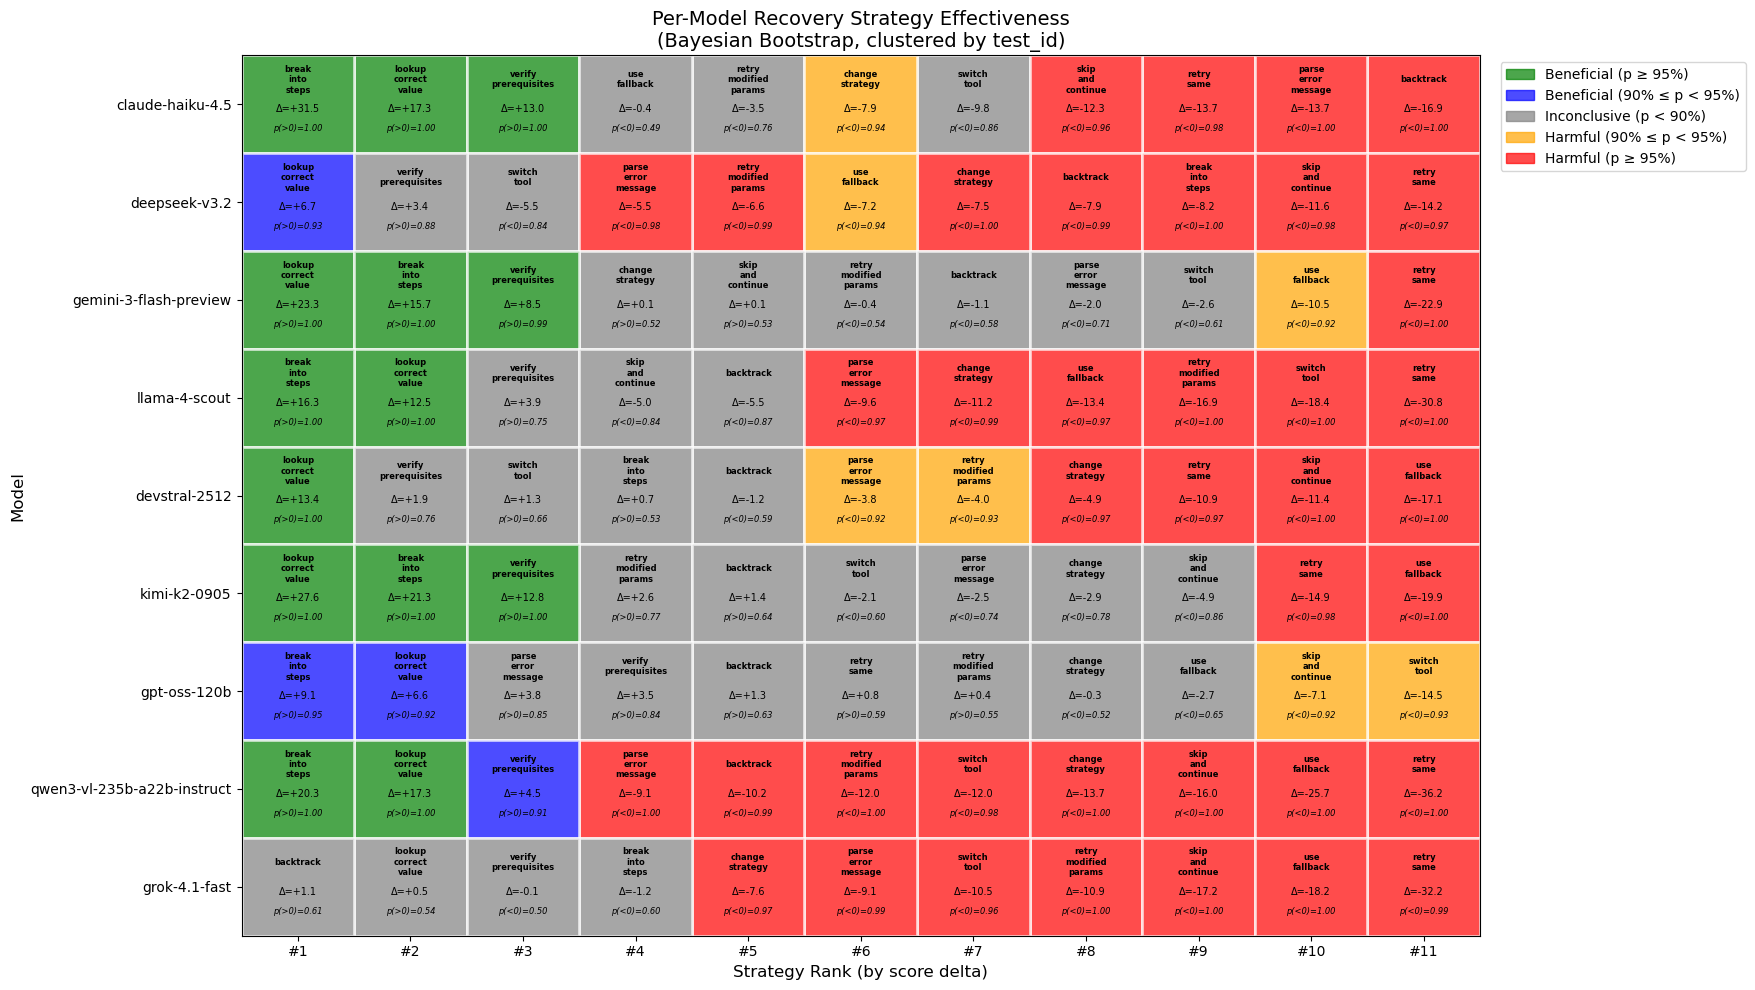


COLOR DISTRIBUTION SUMMARY
  GREEN   :  14 ( 14.1%)
  BLUE    :   4 (  4.0%)
  GRAY    :  35 ( 35.4%)
  ORANGE  :   7 (  7.1%)
  RED     :  39 ( 39.4%)


In [65]:
# Save results and create visualization
from bayes_bootstrap import save_bootstrap_run
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Save the bootstrap results
save_bootstrap_run(
    description="Per-model recovery strategy effectiveness (delta = with_strategy - without_strategy)",
    results={
        "analysis_type": "per_model_strategy_effectiveness",
        "n_models": len(models),
        "n_strategies": len(strategies_to_analyze),
        "strategies_analyzed": strategies_to_analyze,
        "min_usage_threshold": MIN_USAGE_THRESHOLD,
        "n_bootstrap_draws": 10000,
        "results_by_model": df_results.to_dict(orient="records")
    },
    metadata={
        "cluster_key": "test_id",
        "score_field": "score (base_score 0-100)",
        "total_runs_with_recovery": len(runs_with_recovery)
    }
)

# Color coding function
def get_color(row):
    """
    Green: high beneficial (p_gt_0 >= 0.95, delta > 0)
    Blue: moderate beneficial (0.90 <= p_gt_0 < 0.95, delta > 0)
    Orange: moderate harmful (0.90 <= p_lt_0 < 0.95, delta < 0)
    Red: high harmful (p_lt_0 >= 0.95, delta < 0)
    Gray: inconclusive
    """
    delta = row["delta"]
    p_gt_0 = row["p_gt_0"]
    p_lt_0 = row["p_lt_0"]
    
    if delta >= 0:
        if p_gt_0 >= 0.95:
            return "green"
        elif p_gt_0 >= 0.90:
            return "blue"
        else:
            return "gray"
    else:
        if p_lt_0 >= 0.95:
            return "red"
        elif p_lt_0 >= 0.90:
            return "orange"
        else:
            return "gray"

# Add color column
df_results["color"] = df_results.apply(get_color, axis=1)

# Create visualization: heatmap-style grid
fig, ax = plt.subplots(figsize=(18, 10))

# Get unique models and max strategies
unique_models = sorted(df_results["model"].unique())
n_models = len(unique_models)
max_strategies = int(df_results["rank"].max())

# Create grid
model_to_idx = {m: i for i, m in enumerate(unique_models)}

# Plot each cell
for _, row in df_results.iterrows():
    model_idx = model_to_idx[row["model"]]
    rank = int(row["rank"]) - 1  # 0-indexed
    color = row["color"]
    
    # Draw rectangle
    rect = plt.Rectangle((rank, n_models - model_idx - 1), 1, 1, 
                          facecolor=color, edgecolor="white", linewidth=2, alpha=0.7)
    ax.add_patch(rect)
    
    # Prepare text: strategy name, delta, and p-value
    short_name = row["strategy"].replace("_", "\n")[:25]
    delta = row["delta"]
    
    # Show appropriate p-value based on delta direction
    if delta >= 0:
        p_val = row["p_gt_0"]
        p_str = f"p(>0)={p_val:.2f}"
    else:
        p_val = row["p_lt_0"]
        p_str = f"p(<0)={p_val:.2f}"
    
    delta_str = f"Δ={delta:+.1f}"
    
    # Add text in cell
    ax.text(rank + 0.5, n_models - model_idx - 0.25, short_name, 
            ha="center", va="center", fontsize=6, fontweight="bold")
    ax.text(rank + 0.5, n_models - model_idx - 0.55, delta_str,
            ha="center", va="center", fontsize=7)
    ax.text(rank + 0.5, n_models - model_idx - 0.75, p_str,
            ha="center", va="center", fontsize=6, style="italic")

# Set axis limits and labels
ax.set_xlim(0, max_strategies)
ax.set_ylim(0, n_models)

# Y-axis: model names
ax.set_yticks([i + 0.5 for i in range(n_models)])
ax.set_yticklabels([m.split("/")[-1] for m in reversed(unique_models)], fontsize=10)

# X-axis: rank
ax.set_xticks([i + 0.5 for i in range(max_strategies)])
ax.set_xticklabels([f"#{i+1}" for i in range(max_strategies)], fontsize=10)

ax.set_xlabel("Strategy Rank (by score delta)", fontsize=12)
ax.set_ylabel("Model", fontsize=12)
ax.set_title("Per-Model Recovery Strategy Effectiveness\n(Bayesian Bootstrap, clustered by test_id)", fontsize=14)

# Legend
legend_patches = [
    mpatches.Patch(color="green", alpha=0.7, label="Beneficial (p ≥ 95%)"),
    mpatches.Patch(color="blue", alpha=0.7, label="Beneficial (90% ≤ p < 95%)"),
    mpatches.Patch(color="gray", alpha=0.7, label="Inconclusive (p < 90%)"),
    mpatches.Patch(color="orange", alpha=0.7, label="Harmful (90% ≤ p < 95%)"),
    mpatches.Patch(color="red", alpha=0.7, label="Harmful (p ≥ 95%)")
]
ax.legend(handles=legend_patches, loc="upper right", bbox_to_anchor=(1.22, 1))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 60)
print("COLOR DISTRIBUTION SUMMARY")
print("=" * 60)
color_counts = df_results["color"].value_counts()
for color in ["green", "blue", "gray", "orange", "red"]:
    count = color_counts.get(color, 0)
    pct = count / len(df_results) * 100
    print(f"  {color.upper():8s}: {count:3d} ({pct:5.1f}%)")


Total runs with recovery strategies: 3625


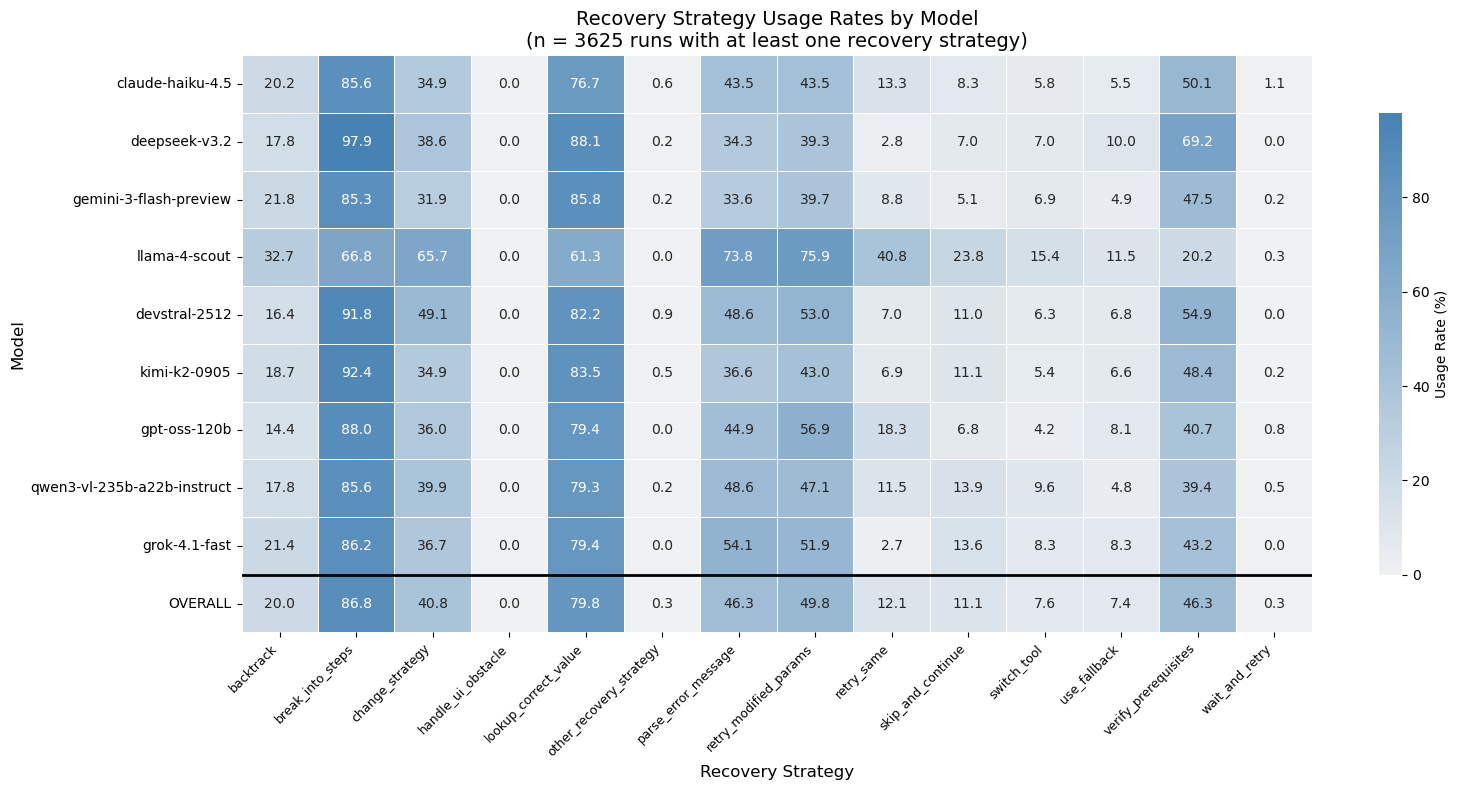


TOP 5 MOST USED STRATEGIES (Overall)
  1. backtrack: 20.0%
  2. break_into_steps: 86.8%
  3. change_strategy: 40.8%
  4. handle_ui_obstacle: 0.0%
  5. lookup_correct_value: 79.8%


In [69]:
# Recovery Strategy Usage Rates (Heatmap by Model)
# Percentage of runs where each recovery strategy was attempted

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get all runs with at least one recovery strategy
runs_with_recovery = [
    run for run in filtered_runs 
    if run.get("recovery_strategies", {}).get("total_recovery_strategies", 0) > 0
]

# Strategy list
all_strategies = [
    "retry_same", "retry_modified_params", "switch_tool", "lookup_correct_value",
    "backtrack", "parse_error_message", "handle_ui_obstacle", "change_strategy",
    "break_into_steps", "verify_prerequisites", "skip_and_continue", "wait_and_retry",
    "use_fallback", "other_recovery_strategy"
]

total_runs = len(runs_with_recovery)
print(f"Total runs with recovery strategies: {total_runs}")

# Compute overall usage rates (for sorting)
overall_usage = {}
for strategy in all_strategies:
    n_used = sum(1 for r in runs_with_recovery if r["recovery_strategies"].get(strategy, 0) == 1)
    overall_usage[strategy] = (n_used / total_runs) * 100 if total_runs > 0 else 0

# Sort strategies by overall usage (descending)
sorted_strategies = sorted(all_strategies)  # Alphabetical order

# Compute per-model usage rates
models = sorted(set(r["model"] for r in runs_with_recovery))
model_usage = {}

for model in models:
    model_runs = [r for r in runs_with_recovery if r["model"] == model]
    n_model = len(model_runs)
    model_usage[model] = {}
    for strategy in all_strategies:
        n_used = sum(1 for r in model_runs if r["recovery_strategies"].get(strategy, 0) == 1)
        model_usage[model][strategy] = (n_used / n_model) * 100 if n_model > 0 else 0

# Create DataFrame
df_heatmap = pd.DataFrame(model_usage).T
df_heatmap.columns = all_strategies

# Reorder columns by overall usage and use short model names
df_heatmap = df_heatmap[sorted_strategies]
df_heatmap.index = [m.split("/")[-1] for m in df_heatmap.index]

# Add overall row
overall_row = pd.DataFrame({s: [overall_usage[s]] for s in sorted_strategies}, index=["OVERALL"])
df_heatmap = pd.concat([df_heatmap, overall_row])

# Create heatmap
fig, ax = plt.subplots(figsize=(16, 8))

# Blue colormap (white to gold/orange)
cmap = sns.light_palette("steelblue", as_cmap=True)

# Create heatmap
sns.heatmap(df_heatmap, annot=True, fmt=".1f", cmap=cmap, 
            linewidths=0.5, linecolor="white",
            cbar_kws={"label": "Usage Rate (%)", "shrink": 0.8},
            ax=ax, vmin=0, vmax=df_heatmap.values.max())

# Formatting
ax.set_xlabel("Recovery Strategy", fontsize=12)
ax.set_ylabel("Model", fontsize=12)
ax.set_title(f"Recovery Strategy Usage Rates by Model\n(n = {total_runs} runs with at least one recovery strategy)", fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=10)

# Add horizontal line to separate OVERALL row
ax.axhline(y=len(models), color="black", linewidth=2)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 60)
print("TOP 5 MOST USED STRATEGIES (Overall)")
print("=" * 60)
for i, strategy in enumerate(sorted_strategies[:5], 1):
    print(f"  {i}. {strategy}: {overall_usage[strategy]:.1f}%")


In [ ]:
# Error Prevalence Rates (Heatmap by Model) — MERGED CATEGORIES
# Percentage of runs where each merged error category was observed
# Uses the same 6-category merging scheme defined earlier in the notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

# Load flattened data
with open('analysis_preprocessed_for_quantitative_evaluation.json') as f:
    all_runs = json.load(f)

print(f"Total runs: {len(all_runs)}")

# === MERGED ERROR CATEGORIES (6 groups) ===
# Matching the merging scheme used elsewhere in this notebook:
#   merr_endpoint_selection = tue_endpoint_selection
#   merr_parameter_errors   = tue_parameter_misuse | he_parameter_hallucination
#   merr_execution_errors   = tue_format_errors | tue_code_errors
#   merr_hallucination      = he_outcome | he_state | he_action | he_context | he_capability | he_other
#   merr_reasoning          = 16 reasoning error types (excl incomplete/premature)
#   merr_incomplete_execution = re_incomplete_execution_error | re_premature_termination_error

def get_merged_errors(run):
    """Apply the 6-category merging scheme."""
    errors = {}
    
    tue = run.get('tool_use_errors', {})
    he = run.get('hallucination_errors', {})
    re = run.get('reasoning_errors', {})
    
    # 1. Endpoint Selection: direct mapping
    errors['endpoint_selection'] = tue.get('endpoint_selection', 0)
    
    # 2. Parameter Errors: parameter_misuse OR parameter_hallucination
    errors['parameter_errors'] = 1 if (
        tue.get('parameter_misuse', 0) == 1 or 
        he.get('parameter_hallucination', 0) == 1
    ) else 0
    
    # 3. Execution Errors: format_errors OR code_errors
    errors['execution_errors'] = 1 if (
        tue.get('format_errors', 0) == 1 or 
        tue.get('code_errors', 0) == 1
    ) else 0
    
    # 4. Hallucination: 6 types (excludes parameter_hallucination which is in parameter_errors)
    errors['hallucination'] = 1 if any([
        he.get('outcome_hallucination', 0) == 1,
        he.get('state_hallucination', 0) == 1,
        he.get('action_hallucination', 0) == 1,
        he.get('context_hallucination', 0) == 1,
        he.get('capability_hallucination', 0) == 1,
        he.get('other_hallucination', 0) == 1,
    ]) else 0
    
    # 5. Reasoning Failures: 16 reasoning error types (excludes incomplete/premature)
    reasoning_keys = [
        'assumption_error', 'state_tracking_error', 'confirmation_bias',
        'goal_misalignment_error', 'reasoning_action_mismatch', 'dependency_ordering_error',
        'causal_reasoning_error', 'instruction_fidelity_error', 'infinite_loop_error',
        'reference_resolution_error', 'time_orientation_error', 'negation_error',
        'scope_generalization_error', 'quantitative_reasoning_error', 'logical_fallacy',
        'other_reasoning_error'
    ]
    errors['reasoning'] = 1 if any(re.get(k, 0) == 1 for k in reasoning_keys) else 0
    
    # 6. Incomplete Execution: incomplete_execution OR premature_termination (combined)
    errors['incomplete_execution'] = 1 if (
        re.get('incomplete_execution_error', 0) == 1 or 
        re.get('premature_termination_error', 0) == 1
    ) else 0
    
    return errors

# Build rows
rows = []
for run in all_runs:
    model = run['model'].split('/')[-1]
    errors = get_merged_errors(run)
    errors['model'] = model
    rows.append(errors)

df_errors = pd.DataFrame(rows)

# Merged categories (6 total, sorted alphabetically)
merged_cats = {
    'endpoint_selection': 'Endpoint Selection',
    'execution_errors': 'Execution Errors',
    'hallucination': 'Hallucination',
    'incomplete_execution': 'Incomplete Execution',
    'parameter_errors': 'Parameter Errors',
    'reasoning': 'Reasoning Failures',
}
error_cols = list(merged_cats.keys())

# Compute prevalence by model (percentage of runs)
models = sorted(df_errors['model'].unique())
model_prevalence = {}

for model in models:
    model_runs = df_errors[df_errors['model'] == model]
    n_model = len(model_runs)
    model_prevalence[model] = {}
    for error in error_cols:
        n_with_error = (model_runs[error] == 1).sum()
        model_prevalence[model][error] = (n_with_error / n_model) * 100 if n_model > 0 else 0

# Create DataFrame
df_heatmap = pd.DataFrame(model_prevalence).T
df_heatmap = df_heatmap[error_cols]

# Compute overall prevalence
overall_prevalence = {}
total_runs = len(df_errors)
for error in error_cols:
    n_with_error = (df_errors[error] == 1).sum()
    overall_prevalence[error] = (n_with_error / total_runs) * 100

# Add overall row
overall_row = pd.DataFrame({e: [overall_prevalence[e]] for e in error_cols}, index=["OVERALL"])
df_heatmap = pd.concat([df_heatmap, overall_row])

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 7))

# Red colormap (white to firebrick red)
cmap = sns.light_palette("firebrick", as_cmap=True)

# Create heatmap with merged category labels
sns.heatmap(df_heatmap, annot=True, fmt=".1f", cmap=cmap, 
            linewidths=0.5, linecolor="white",
            xticklabels=[merged_cats[c] for c in error_cols],
            cbar_kws={"label": "Error Prevalence (%)", "shrink": 0.8},
            ax=ax, vmin=0, vmax=df_heatmap.values.max())

# Formatting
ax.set_xlabel("Error Category (Merged)", fontsize=12)
ax.set_ylabel("Model", fontsize=12)
ax.set_title(f"Error Prevalence by Model — Merged Categories (% of runs)\n(n = {total_runs} runs across 6 merged error categories)", fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=10)

# Add horizontal line to separate OVERALL row
ax.axhline(y=len(models), color="black", linewidth=2)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 70)
print("MERGED ERROR CATEGORY DEFINITIONS (6 categories):")
print("=" * 70)
print("  endpoint_selection    <- tue_endpoint_selection")
print("  parameter_errors      <- tue_parameter_misuse | he_parameter_hallucination")
print("  execution_errors      <- tue_format_errors | tue_code_errors")
print("  hallucination         <- he_outcome | he_state | he_action | he_context |")
print("                           he_capability | he_other (excludes param_halluc)")
print("  reasoning             <- 16 reasoning error types (excl incomplete/premature)")
print("  incomplete_execution  <- re_incomplete_execution | re_premature_termination")

print("\n" + "=" * 70)
print("ERROR PREVALENCE BY CATEGORY (Overall)")
print("=" * 70)
for error in sorted(error_cols, key=lambda x: overall_prevalence[x], reverse=True):
    print(f"  {merged_cats[error]:25s}: {overall_prevalence[error]:.1f}%")